In [1]:
# https://www.kaggle.com/mathormad/inceptionv3-baseline-lb-0-379/code
# validation augmentation is True, augmentation someof, TTA

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")
SIZE = 512

In [3]:
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric/notebook
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) + (1 - K.mean(f1))

In [4]:
# Load dataset info
path_to_train = '../data/train/'
data = pd.read_csv('../data/train.csv')
path_to_external_data = '../data/external_data/external_data_1/'
edata = pd.read_csv('../data/external_data.csv')

In [5]:
data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})

for name, labels in zip(edata['id'], edata['labels'].str.strip('[]')):
    labels = labels.split(',')
    train_dataset_info.append({
        'path':os.path.join(path_to_external_data, name),
        'labels':np.array([int(label) for label in labels])})

train_dataset_info = np.array(train_dataset_info)

In [7]:
train_dataset_info

array([{'path': '../data/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': '../data/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': '../data/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': '../data/external_data/external_data_1/ENSG00000284292-RP5-900K19.2_0', 'labels': array([25])},
       {'path': '../data/external_data/external_data_1/ENSG00000284308-C2orf81_0', 'labels': array([3])},
       {'path': '../data/external_data/external_data_1/ENSG00000284413-BTBD8_0', 'labels': array([0])}],
      dtype=object)

In [8]:
len(train_dataset_info)

43832

In [9]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    path = X_train_batch[i]['path']
                    if 'external' not in path:
                        image = data_generator.load_image(path, shape)
                    else:
                        image = data_generator.load_image2(path, shape)
                    if augument:
                        image = data_generator.augment2(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
        zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_yellow_ch),
#             zero_data, zero_data), -1)
#         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2))
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    def load_image2(path, shape):
        image = np.array(Image.open(path+'.png'))
#         w, h = 512, 512
#         zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_yellow_ch),
#             zero_data, zero_data), -1)
#         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2))
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug
    def augment2(image):
        augment_img = iaa.Sequential([
            iaa.SomeOf((0,5),[
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug


In [10]:
%matplotlib inline

In [11]:
img = data_generator.load_image(train_dataset_info[0]['path'], (SIZE, SIZE, 3))

In [12]:
img.shape

(512, 512, 3)

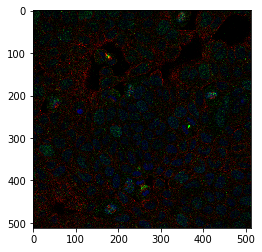

In [13]:
plt.imshow(img)

In [14]:
img = data_generator.load_image2(train_dataset_info[40000]['path'], (SIZE, SIZE, 3))

In [15]:
img2 = data_generator.augment(img)

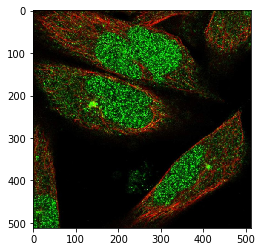

In [16]:
plt.imshow(img2)

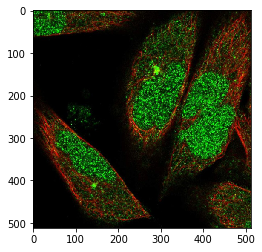

In [17]:
img2 = data_generator.augment2(img)
plt.imshow(img2)

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,  GlobalAveragePooling2D
from keras.layers import BatchNormalization, Input, Conv2D
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

Using TensorFlow backend.


In [19]:
# def create_model(input_shape, n_out):
#     input_tensor = Input(shape=input_shape)
#     base_model = InceptionResNetV2(include_top=False,
#                    weights='imagenet',
#                    input_shape=input_shape)
#     bn = BatchNormalization()(input_tensor)
#     x = base_model(bn)
#     x = Conv2D(256, kernel_size=(1,1), activation='relu')(x)
#     x = Flatten()(x)
#     x = Dropout(0.5)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     output = Dense(n_out, activation='sigmoid')(x)
#     model = Model(input_tensor, output)
    
#     return model

In [20]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    bn = BatchNormalization(name='bn1')(input_tensor)
    x = base_model(bn)
    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [21]:
# model = InceptionV3(include_top=False,
#                    weights='imagenet',
#                    input_shape=(512,512,3))
# #     bn = BatchNormalization()(input_tensor)
# model.summary()
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
# __________________________________________________________________________________________________
# conv2d_408 (Conv2D)             (None, 255, 255, 32) 864         input_4[0][0]                    
# __________________________________________________________________________________________________
# batch_normalization_408 (BatchN (None, 255, 255, 32) 96          conv2d_408[0][0]                 
# __________________________________________________________________________________________________
# activation_407 (Activation)     (None, 255, 255, 32) 0           batch_normalization_408[0][0]    
# __________________________________________________________________________________________________
# conv2d_409 (Conv2D)             (None, 253, 253, 32) 9216        activation_407[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_409 (BatchN (None, 253, 253, 32) 96          conv2d_409[0][0]                 
# __________________________________________________________________________________________________
# activation_408 (Activation)     (None, 253, 253, 32) 0           batch_normalization_409[0][0]    
# __________________________________________________________________________________________________
# conv2d_410 (Conv2D)             (None, 253, 253, 64) 18432       activation_408[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_410 (BatchN (None, 253, 253, 64) 192         conv2d_410[0][0]                 
# __________________________________________________________________________________________________
# activation_409 (Activation)     (None, 253, 253, 64) 0           batch_normalization_410[0][0]    
# __________________________________________________________________________________________________
# max_pooling2d_9 (MaxPooling2D)  (None, 126, 126, 64) 0           activation_409[0][0]             
# __________________________________________________________________________________________________
# conv2d_411 (Conv2D)             (None, 126, 126, 80) 5120        max_pooling2d_9[0][0]            
# __________________________________________________________________________________________________
# batch_normalization_411 (BatchN (None, 126, 126, 80) 240         conv2d_411[0][0]                 
# __________________________________________________________________________________________________
# activation_410 (Activation)     (None, 126, 126, 80) 0           batch_normalization_411[0][0]    
# __________________________________________________________________________________________________
# conv2d_412 (Conv2D)             (None, 124, 124, 192 138240      activation_410[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_412 (BatchN (None, 124, 124, 192 576         conv2d_412[0][0]                 
# __________________________________________________________________________________________________
# activation_411 (Activation)     (None, 124, 124, 192 0           batch_normalization_412[0][0]    
# __________________________________________________________________________________________________
# max_pooling2d_10 (MaxPooling2D) (None, 61, 61, 192)  0           activation_411[0][0]             
# __________________________________________________________________________________________________
# conv2d_416 (Conv2D)             (None, 61, 61, 64)   12288       max_pooling2d_10[0][0]           
# __________________________________________________________________________________________________
# batch_normalization_416 (BatchN (None, 61, 61, 64)   192         conv2d_416[0][0]                 
# __________________________________________________________________________________________________
# activation_415 (Activation)     (None, 61, 61, 64)   0           batch_normalization_416[0][0]    
# __________________________________________________________________________________________________
# conv2d_414 (Conv2D)             (None, 61, 61, 48)   9216        max_pooling2d_10[0][0]           
# __________________________________________________________________________________________________
# conv2d_417 (Conv2D)             (None, 61, 61, 96)   55296       activation_415[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_414 (BatchN (None, 61, 61, 48)   144         conv2d_414[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_417 (BatchN (None, 61, 61, 96)   288         conv2d_417[0][0]                 
# __________________________________________________________________________________________________
# activation_413 (Activation)     (None, 61, 61, 48)   0           batch_normalization_414[0][0]    
# __________________________________________________________________________________________________
# activation_416 (Activation)     (None, 61, 61, 96)   0           batch_normalization_417[0][0]    
# __________________________________________________________________________________________________
# average_pooling2d_3 (AveragePoo (None, 61, 61, 192)  0           max_pooling2d_10[0][0]           
# __________________________________________________________________________________________________
# conv2d_413 (Conv2D)             (None, 61, 61, 64)   12288       max_pooling2d_10[0][0]           
# __________________________________________________________________________________________________
# conv2d_415 (Conv2D)             (None, 61, 61, 64)   76800       activation_413[0][0]             
# __________________________________________________________________________________________________
# conv2d_418 (Conv2D)             (None, 61, 61, 96)   82944       activation_416[0][0]             
# __________________________________________________________________________________________________
# conv2d_419 (Conv2D)             (None, 61, 61, 32)   6144        average_pooling2d_3[0][0]        
# __________________________________________________________________________________________________
# batch_normalization_413 (BatchN (None, 61, 61, 64)   192         conv2d_413[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_415 (BatchN (None, 61, 61, 64)   192         conv2d_415[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_418 (BatchN (None, 61, 61, 96)   288         conv2d_418[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_419 (BatchN (None, 61, 61, 32)   96          conv2d_419[0][0]                 
# __________________________________________________________________________________________________
# activation_412 (Activation)     (None, 61, 61, 64)   0           batch_normalization_413[0][0]    
# __________________________________________________________________________________________________
# activation_414 (Activation)     (None, 61, 61, 64)   0           batch_normalization_415[0][0]    
# __________________________________________________________________________________________________
# activation_417 (Activation)     (None, 61, 61, 96)   0           batch_normalization_418[0][0]    
# __________________________________________________________________________________________________
# activation_418 (Activation)     (None, 61, 61, 32)   0           batch_normalization_419[0][0]    
# __________________________________________________________________________________________________
# mixed0 (Concatenate)            (None, 61, 61, 256)  0           activation_412[0][0]             
#                                                                  activation_414[0][0]             
#                                                                  activation_417[0][0]             
#                                                                  activation_418[0][0]             
# __________________________________________________________________________________________________
# conv2d_423 (Conv2D)             (None, 61, 61, 64)   16384       mixed0[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_423 (BatchN (None, 61, 61, 64)   192         conv2d_423[0][0]                 
# __________________________________________________________________________________________________
# activation_422 (Activation)     (None, 61, 61, 64)   0           batch_normalization_423[0][0]    
# __________________________________________________________________________________________________
# conv2d_421 (Conv2D)             (None, 61, 61, 48)   12288       mixed0[0][0]                     
# __________________________________________________________________________________________________
# conv2d_424 (Conv2D)             (None, 61, 61, 96)   55296       activation_422[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_421 (BatchN (None, 61, 61, 48)   144         conv2d_421[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_424 (BatchN (None, 61, 61, 96)   288         conv2d_424[0][0]                 
# __________________________________________________________________________________________________
# activation_420 (Activation)     (None, 61, 61, 48)   0           batch_normalization_421[0][0]    
# __________________________________________________________________________________________________
# activation_423 (Activation)     (None, 61, 61, 96)   0           batch_normalization_424[0][0]    
# __________________________________________________________________________________________________
# average_pooling2d_4 (AveragePoo (None, 61, 61, 256)  0           mixed0[0][0]                     
# __________________________________________________________________________________________________
# conv2d_420 (Conv2D)             (None, 61, 61, 64)   16384       mixed0[0][0]                     
# __________________________________________________________________________________________________
# conv2d_422 (Conv2D)             (None, 61, 61, 64)   76800       activation_420[0][0]             
# __________________________________________________________________________________________________
# conv2d_425 (Conv2D)             (None, 61, 61, 96)   82944       activation_423[0][0]             
# __________________________________________________________________________________________________
# conv2d_426 (Conv2D)             (None, 61, 61, 64)   16384       average_pooling2d_4[0][0]        
# __________________________________________________________________________________________________
# batch_normalization_420 (BatchN (None, 61, 61, 64)   192         conv2d_420[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_422 (BatchN (None, 61, 61, 64)   192         conv2d_422[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_425 (BatchN (None, 61, 61, 96)   288         conv2d_425[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_426 (BatchN (None, 61, 61, 64)   192         conv2d_426[0][0]                 
# __________________________________________________________________________________________________
# activation_419 (Activation)     (None, 61, 61, 64)   0           batch_normalization_420[0][0]    
# __________________________________________________________________________________________________
# activation_421 (Activation)     (None, 61, 61, 64)   0           batch_normalization_422[0][0]    
# __________________________________________________________________________________________________
# activation_424 (Activation)     (None, 61, 61, 96)   0           batch_normalization_425[0][0]    
# __________________________________________________________________________________________________
# activation_425 (Activation)     (None, 61, 61, 64)   0           batch_normalization_426[0][0]    
# __________________________________________________________________________________________________
# mixed1 (Concatenate)            (None, 61, 61, 288)  0           activation_419[0][0]             
#                                                                  activation_421[0][0]             
#                                                                  activation_424[0][0]             
#                                                                  activation_425[0][0]             
# __________________________________________________________________________________________________
# conv2d_430 (Conv2D)             (None, 61, 61, 64)   18432       mixed1[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_430 (BatchN (None, 61, 61, 64)   192         conv2d_430[0][0]                 
# __________________________________________________________________________________________________
# activation_429 (Activation)     (None, 61, 61, 64)   0           batch_normalization_430[0][0]    
# __________________________________________________________________________________________________
# conv2d_428 (Conv2D)             (None, 61, 61, 48)   13824       mixed1[0][0]                     
# __________________________________________________________________________________________________
# conv2d_431 (Conv2D)             (None, 61, 61, 96)   55296       activation_429[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_428 (BatchN (None, 61, 61, 48)   144         conv2d_428[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_431 (BatchN (None, 61, 61, 96)   288         conv2d_431[0][0]                 
# __________________________________________________________________________________________________
# activation_427 (Activation)     (None, 61, 61, 48)   0           batch_normalization_428[0][0]    
# __________________________________________________________________________________________________
# activation_430 (Activation)     (None, 61, 61, 96)   0           batch_normalization_431[0][0]    
# __________________________________________________________________________________________________
# average_pooling2d_5 (AveragePoo (None, 61, 61, 288)  0           mixed1[0][0]                     
# __________________________________________________________________________________________________
# conv2d_427 (Conv2D)             (None, 61, 61, 64)   18432       mixed1[0][0]                     
# __________________________________________________________________________________________________
# conv2d_429 (Conv2D)             (None, 61, 61, 64)   76800       activation_427[0][0]             
# __________________________________________________________________________________________________
# conv2d_432 (Conv2D)             (None, 61, 61, 96)   82944       activation_430[0][0]             
# __________________________________________________________________________________________________
# conv2d_433 (Conv2D)             (None, 61, 61, 64)   18432       average_pooling2d_5[0][0]        
# __________________________________________________________________________________________________
# batch_normalization_427 (BatchN (None, 61, 61, 64)   192         conv2d_427[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_429 (BatchN (None, 61, 61, 64)   192         conv2d_429[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_432 (BatchN (None, 61, 61, 96)   288         conv2d_432[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_433 (BatchN (None, 61, 61, 64)   192         conv2d_433[0][0]                 
# __________________________________________________________________________________________________
# activation_426 (Activation)     (None, 61, 61, 64)   0           batch_normalization_427[0][0]    
# __________________________________________________________________________________________________
# activation_428 (Activation)     (None, 61, 61, 64)   0           batch_normalization_429[0][0]    
# __________________________________________________________________________________________________
# activation_431 (Activation)     (None, 61, 61, 96)   0           batch_normalization_432[0][0]    
# __________________________________________________________________________________________________
# activation_432 (Activation)     (None, 61, 61, 64)   0           batch_normalization_433[0][0]    
# __________________________________________________________________________________________________
# mixed2 (Concatenate)            (None, 61, 61, 288)  0           activation_426[0][0]             
#                                                                  activation_428[0][0]             
#                                                                  activation_431[0][0]             
#                                                                  activation_432[0][0]             
# __________________________________________________________________________________________________
# conv2d_435 (Conv2D)             (None, 61, 61, 64)   18432       mixed2[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_435 (BatchN (None, 61, 61, 64)   192         conv2d_435[0][0]                 
# __________________________________________________________________________________________________
# activation_434 (Activation)     (None, 61, 61, 64)   0           batch_normalization_435[0][0]    
# __________________________________________________________________________________________________
# conv2d_436 (Conv2D)             (None, 61, 61, 96)   55296       activation_434[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_436 (BatchN (None, 61, 61, 96)   288         conv2d_436[0][0]                 
# __________________________________________________________________________________________________
# activation_435 (Activation)     (None, 61, 61, 96)   0           batch_normalization_436[0][0]    
# __________________________________________________________________________________________________
# conv2d_434 (Conv2D)             (None, 30, 30, 384)  995328      mixed2[0][0]                     
# __________________________________________________________________________________________________
# conv2d_437 (Conv2D)             (None, 30, 30, 96)   82944       activation_435[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_434 (BatchN (None, 30, 30, 384)  1152        conv2d_434[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_437 (BatchN (None, 30, 30, 96)   288         conv2d_437[0][0]                 
# __________________________________________________________________________________________________
# activation_433 (Activation)     (None, 30, 30, 384)  0           batch_normalization_434[0][0]    
# __________________________________________________________________________________________________
# activation_436 (Activation)     (None, 30, 30, 96)   0           batch_normalization_437[0][0]    
# __________________________________________________________________________________________________
# max_pooling2d_11 (MaxPooling2D) (None, 30, 30, 288)  0           mixed2[0][0]                     
# __________________________________________________________________________________________________
# mixed3 (Concatenate)            (None, 30, 30, 768)  0           activation_433[0][0]             
#                                                                  activation_436[0][0]             
#                                                                  max_pooling2d_11[0][0]           
# __________________________________________________________________________________________________
# conv2d_442 (Conv2D)             (None, 30, 30, 128)  98304       mixed3[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_442 (BatchN (None, 30, 30, 128)  384         conv2d_442[0][0]                 
# __________________________________________________________________________________________________
# activation_441 (Activation)     (None, 30, 30, 128)  0           batch_normalization_442[0][0]    
# __________________________________________________________________________________________________
# conv2d_443 (Conv2D)             (None, 30, 30, 128)  114688      activation_441[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_443 (BatchN (None, 30, 30, 128)  384         conv2d_443[0][0]                 
# __________________________________________________________________________________________________
# activation_442 (Activation)     (None, 30, 30, 128)  0           batch_normalization_443[0][0]    
# __________________________________________________________________________________________________
# conv2d_439 (Conv2D)             (None, 30, 30, 128)  98304       mixed3[0][0]                     
# __________________________________________________________________________________________________
# conv2d_444 (Conv2D)             (None, 30, 30, 128)  114688      activation_442[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_439 (BatchN (None, 30, 30, 128)  384         conv2d_439[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_444 (BatchN (None, 30, 30, 128)  384         conv2d_444[0][0]                 
# __________________________________________________________________________________________________
# activation_438 (Activation)     (None, 30, 30, 128)  0           batch_normalization_439[0][0]    
# __________________________________________________________________________________________________
# activation_443 (Activation)     (None, 30, 30, 128)  0           batch_normalization_444[0][0]    
# __________________________________________________________________________________________________
# conv2d_440 (Conv2D)             (None, 30, 30, 128)  114688      activation_438[0][0]             
# __________________________________________________________________________________________________
# conv2d_445 (Conv2D)             (None, 30, 30, 128)  114688      activation_443[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_440 (BatchN (None, 30, 30, 128)  384         conv2d_440[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_445 (BatchN (None, 30, 30, 128)  384         conv2d_445[0][0]                 
# __________________________________________________________________________________________________
# activation_439 (Activation)     (None, 30, 30, 128)  0           batch_normalization_440[0][0]    
# __________________________________________________________________________________________________
# activation_444 (Activation)     (None, 30, 30, 128)  0           batch_normalization_445[0][0]    
# __________________________________________________________________________________________________
# average_pooling2d_6 (AveragePoo (None, 30, 30, 768)  0           mixed3[0][0]                     
# __________________________________________________________________________________________________
# conv2d_438 (Conv2D)             (None, 30, 30, 192)  147456      mixed3[0][0]                     
# __________________________________________________________________________________________________
# conv2d_441 (Conv2D)             (None, 30, 30, 192)  172032      activation_439[0][0]             
# __________________________________________________________________________________________________
# conv2d_446 (Conv2D)             (None, 30, 30, 192)  172032      activation_444[0][0]             
# __________________________________________________________________________________________________
# conv2d_447 (Conv2D)             (None, 30, 30, 192)  147456      average_pooling2d_6[0][0]        
# __________________________________________________________________________________________________
# batch_normalization_438 (BatchN (None, 30, 30, 192)  576         conv2d_438[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_441 (BatchN (None, 30, 30, 192)  576         conv2d_441[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_446 (BatchN (None, 30, 30, 192)  576         conv2d_446[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_447 (BatchN (None, 30, 30, 192)  576         conv2d_447[0][0]                 
# __________________________________________________________________________________________________
# activation_437 (Activation)     (None, 30, 30, 192)  0           batch_normalization_438[0][0]    
# __________________________________________________________________________________________________
# activation_440 (Activation)     (None, 30, 30, 192)  0           batch_normalization_441[0][0]    
# __________________________________________________________________________________________________
# activation_445 (Activation)     (None, 30, 30, 192)  0           batch_normalization_446[0][0]    
# __________________________________________________________________________________________________
# activation_446 (Activation)     (None, 30, 30, 192)  0           batch_normalization_447[0][0]    
# __________________________________________________________________________________________________
# mixed4 (Concatenate)            (None, 30, 30, 768)  0           activation_437[0][0]             
#                                                                  activation_440[0][0]             
#                                                                  activation_445[0][0]             
#                                                                  activation_446[0][0]             
# __________________________________________________________________________________________________
# conv2d_452 (Conv2D)             (None, 30, 30, 160)  122880      mixed4[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_452 (BatchN (None, 30, 30, 160)  480         conv2d_452[0][0]                 
# __________________________________________________________________________________________________
# activation_451 (Activation)     (None, 30, 30, 160)  0           batch_normalization_452[0][0]    
# __________________________________________________________________________________________________
# conv2d_453 (Conv2D)             (None, 30, 30, 160)  179200      activation_451[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_453 (BatchN (None, 30, 30, 160)  480         conv2d_453[0][0]                 
# __________________________________________________________________________________________________
# activation_452 (Activation)     (None, 30, 30, 160)  0           batch_normalization_453[0][0]    
# __________________________________________________________________________________________________
# conv2d_449 (Conv2D)             (None, 30, 30, 160)  122880      mixed4[0][0]                     
# __________________________________________________________________________________________________
# conv2d_454 (Conv2D)             (None, 30, 30, 160)  179200      activation_452[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_449 (BatchN (None, 30, 30, 160)  480         conv2d_449[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_454 (BatchN (None, 30, 30, 160)  480         conv2d_454[0][0]                 
# __________________________________________________________________________________________________
# activation_448 (Activation)     (None, 30, 30, 160)  0           batch_normalization_449[0][0]    
# __________________________________________________________________________________________________
# activation_453 (Activation)     (None, 30, 30, 160)  0           batch_normalization_454[0][0]    
# __________________________________________________________________________________________________
# conv2d_450 (Conv2D)             (None, 30, 30, 160)  179200      activation_448[0][0]             
# __________________________________________________________________________________________________
# conv2d_455 (Conv2D)             (None, 30, 30, 160)  179200      activation_453[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_450 (BatchN (None, 30, 30, 160)  480         conv2d_450[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_455 (BatchN (None, 30, 30, 160)  480         conv2d_455[0][0]                 
# __________________________________________________________________________________________________
# activation_449 (Activation)     (None, 30, 30, 160)  0           batch_normalization_450[0][0]    
# __________________________________________________________________________________________________
# activation_454 (Activation)     (None, 30, 30, 160)  0           batch_normalization_455[0][0]    
# __________________________________________________________________________________________________
# average_pooling2d_7 (AveragePoo (None, 30, 30, 768)  0           mixed4[0][0]                     
# __________________________________________________________________________________________________
# conv2d_448 (Conv2D)             (None, 30, 30, 192)  147456      mixed4[0][0]                     
# __________________________________________________________________________________________________
# conv2d_451 (Conv2D)             (None, 30, 30, 192)  215040      activation_449[0][0]             
# __________________________________________________________________________________________________
# conv2d_456 (Conv2D)             (None, 30, 30, 192)  215040      activation_454[0][0]             
# __________________________________________________________________________________________________
# conv2d_457 (Conv2D)             (None, 30, 30, 192)  147456      average_pooling2d_7[0][0]        
# __________________________________________________________________________________________________
# batch_normalization_448 (BatchN (None, 30, 30, 192)  576         conv2d_448[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_451 (BatchN (None, 30, 30, 192)  576         conv2d_451[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_456 (BatchN (None, 30, 30, 192)  576         conv2d_456[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_457 (BatchN (None, 30, 30, 192)  576         conv2d_457[0][0]                 
# __________________________________________________________________________________________________
# activation_447 (Activation)     (None, 30, 30, 192)  0           batch_normalization_448[0][0]    
# __________________________________________________________________________________________________
# activation_450 (Activation)     (None, 30, 30, 192)  0           batch_normalization_451[0][0]    
# __________________________________________________________________________________________________
# activation_455 (Activation)     (None, 30, 30, 192)  0           batch_normalization_456[0][0]    
# __________________________________________________________________________________________________
# activation_456 (Activation)     (None, 30, 30, 192)  0           batch_normalization_457[0][0]    
# __________________________________________________________________________________________________
# mixed5 (Concatenate)            (None, 30, 30, 768)  0           activation_447[0][0]             
#                                                                  activation_450[0][0]             
#                                                                  activation_455[0][0]             
#                                                                  activation_456[0][0]             
# __________________________________________________________________________________________________
# conv2d_462 (Conv2D)             (None, 30, 30, 160)  122880      mixed5[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_462 (BatchN (None, 30, 30, 160)  480         conv2d_462[0][0]                 
# __________________________________________________________________________________________________
# activation_461 (Activation)     (None, 30, 30, 160)  0           batch_normalization_462[0][0]    
# __________________________________________________________________________________________________
# conv2d_463 (Conv2D)             (None, 30, 30, 160)  179200      activation_461[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_463 (BatchN (None, 30, 30, 160)  480         conv2d_463[0][0]                 
# __________________________________________________________________________________________________
# activation_462 (Activation)     (None, 30, 30, 160)  0           batch_normalization_463[0][0]    
# __________________________________________________________________________________________________
# conv2d_459 (Conv2D)             (None, 30, 30, 160)  122880      mixed5[0][0]                     
# __________________________________________________________________________________________________
# conv2d_464 (Conv2D)             (None, 30, 30, 160)  179200      activation_462[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_459 (BatchN (None, 30, 30, 160)  480         conv2d_459[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_464 (BatchN (None, 30, 30, 160)  480         conv2d_464[0][0]                 
# __________________________________________________________________________________________________
# activation_458 (Activation)     (None, 30, 30, 160)  0           batch_normalization_459[0][0]    
# __________________________________________________________________________________________________
# activation_463 (Activation)     (None, 30, 30, 160)  0           batch_normalization_464[0][0]    
# __________________________________________________________________________________________________
# conv2d_460 (Conv2D)             (None, 30, 30, 160)  179200      activation_458[0][0]             
# __________________________________________________________________________________________________
# conv2d_465 (Conv2D)             (None, 30, 30, 160)  179200      activation_463[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_460 (BatchN (None, 30, 30, 160)  480         conv2d_460[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_465 (BatchN (None, 30, 30, 160)  480         conv2d_465[0][0]                 
# __________________________________________________________________________________________________
# activation_459 (Activation)     (None, 30, 30, 160)  0           batch_normalization_460[0][0]    
# __________________________________________________________________________________________________
# activation_464 (Activation)     (None, 30, 30, 160)  0           batch_normalization_465[0][0]    
# __________________________________________________________________________________________________
# average_pooling2d_8 (AveragePoo (None, 30, 30, 768)  0           mixed5[0][0]                     
# __________________________________________________________________________________________________
# conv2d_458 (Conv2D)             (None, 30, 30, 192)  147456      mixed5[0][0]                     
# __________________________________________________________________________________________________
# conv2d_461 (Conv2D)             (None, 30, 30, 192)  215040      activation_459[0][0]             
# __________________________________________________________________________________________________
# conv2d_466 (Conv2D)             (None, 30, 30, 192)  215040      activation_464[0][0]             
# __________________________________________________________________________________________________
# conv2d_467 (Conv2D)             (None, 30, 30, 192)  147456      average_pooling2d_8[0][0]        
# __________________________________________________________________________________________________
# batch_normalization_458 (BatchN (None, 30, 30, 192)  576         conv2d_458[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_461 (BatchN (None, 30, 30, 192)  576         conv2d_461[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_466 (BatchN (None, 30, 30, 192)  576         conv2d_466[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_467 (BatchN (None, 30, 30, 192)  576         conv2d_467[0][0]                 
# __________________________________________________________________________________________________
# activation_457 (Activation)     (None, 30, 30, 192)  0           batch_normalization_458[0][0]    
# __________________________________________________________________________________________________
# activation_460 (Activation)     (None, 30, 30, 192)  0           batch_normalization_461[0][0]    
# __________________________________________________________________________________________________
# activation_465 (Activation)     (None, 30, 30, 192)  0           batch_normalization_466[0][0]    
# __________________________________________________________________________________________________
# activation_466 (Activation)     (None, 30, 30, 192)  0           batch_normalization_467[0][0]    
# __________________________________________________________________________________________________
# mixed6 (Concatenate)            (None, 30, 30, 768)  0           activation_457[0][0]             
#                                                                  activation_460[0][0]             
#                                                                  activation_465[0][0]             
#                                                                  activation_466[0][0]             
# __________________________________________________________________________________________________
# conv2d_472 (Conv2D)             (None, 30, 30, 192)  147456      mixed6[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_472 (BatchN (None, 30, 30, 192)  576         conv2d_472[0][0]                 
# __________________________________________________________________________________________________
# activation_471 (Activation)     (None, 30, 30, 192)  0           batch_normalization_472[0][0]    
# __________________________________________________________________________________________________
# conv2d_473 (Conv2D)             (None, 30, 30, 192)  258048      activation_471[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_473 (BatchN (None, 30, 30, 192)  576         conv2d_473[0][0]                 
# __________________________________________________________________________________________________
# activation_472 (Activation)     (None, 30, 30, 192)  0           batch_normalization_473[0][0]    
# __________________________________________________________________________________________________
# conv2d_469 (Conv2D)             (None, 30, 30, 192)  147456      mixed6[0][0]                     
# __________________________________________________________________________________________________
# conv2d_474 (Conv2D)             (None, 30, 30, 192)  258048      activation_472[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_469 (BatchN (None, 30, 30, 192)  576         conv2d_469[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_474 (BatchN (None, 30, 30, 192)  576         conv2d_474[0][0]                 
# __________________________________________________________________________________________________
# activation_468 (Activation)     (None, 30, 30, 192)  0           batch_normalization_469[0][0]    
# __________________________________________________________________________________________________
# activation_473 (Activation)     (None, 30, 30, 192)  0           batch_normalization_474[0][0]    
# __________________________________________________________________________________________________
# conv2d_470 (Conv2D)             (None, 30, 30, 192)  258048      activation_468[0][0]             
# __________________________________________________________________________________________________
# conv2d_475 (Conv2D)             (None, 30, 30, 192)  258048      activation_473[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_470 (BatchN (None, 30, 30, 192)  576         conv2d_470[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_475 (BatchN (None, 30, 30, 192)  576         conv2d_475[0][0]                 
# __________________________________________________________________________________________________
# activation_469 (Activation)     (None, 30, 30, 192)  0           batch_normalization_470[0][0]    
# __________________________________________________________________________________________________
# activation_474 (Activation)     (None, 30, 30, 192)  0           batch_normalization_475[0][0]    
# __________________________________________________________________________________________________
# average_pooling2d_9 (AveragePoo (None, 30, 30, 768)  0           mixed6[0][0]                     
# __________________________________________________________________________________________________
# conv2d_468 (Conv2D)             (None, 30, 30, 192)  147456      mixed6[0][0]                     
# __________________________________________________________________________________________________
# conv2d_471 (Conv2D)             (None, 30, 30, 192)  258048      activation_469[0][0]             
# __________________________________________________________________________________________________
# conv2d_476 (Conv2D)             (None, 30, 30, 192)  258048      activation_474[0][0]             
# __________________________________________________________________________________________________
# conv2d_477 (Conv2D)             (None, 30, 30, 192)  147456      average_pooling2d_9[0][0]        
# __________________________________________________________________________________________________
# batch_normalization_468 (BatchN (None, 30, 30, 192)  576         conv2d_468[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_471 (BatchN (None, 30, 30, 192)  576         conv2d_471[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_476 (BatchN (None, 30, 30, 192)  576         conv2d_476[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_477 (BatchN (None, 30, 30, 192)  576         conv2d_477[0][0]                 
# __________________________________________________________________________________________________
# activation_467 (Activation)     (None, 30, 30, 192)  0           batch_normalization_468[0][0]    
# __________________________________________________________________________________________________
# activation_470 (Activation)     (None, 30, 30, 192)  0           batch_normalization_471[0][0]    
# __________________________________________________________________________________________________
# activation_475 (Activation)     (None, 30, 30, 192)  0           batch_normalization_476[0][0]    
# __________________________________________________________________________________________________
# activation_476 (Activation)     (None, 30, 30, 192)  0           batch_normalization_477[0][0]    
# __________________________________________________________________________________________________
# mixed7 (Concatenate)            (None, 30, 30, 768)  0           activation_467[0][0]             
#                                                                  activation_470[0][0]             
#                                                                  activation_475[0][0]             
#                                                                  activation_476[0][0]             
# __________________________________________________________________________________________________
# conv2d_480 (Conv2D)             (None, 30, 30, 192)  147456      mixed7[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_480 (BatchN (None, 30, 30, 192)  576         conv2d_480[0][0]                 
# __________________________________________________________________________________________________
# activation_479 (Activation)     (None, 30, 30, 192)  0           batch_normalization_480[0][0]    
# __________________________________________________________________________________________________
# conv2d_481 (Conv2D)             (None, 30, 30, 192)  258048      activation_479[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_481 (BatchN (None, 30, 30, 192)  576         conv2d_481[0][0]                 
# __________________________________________________________________________________________________
# activation_480 (Activation)     (None, 30, 30, 192)  0           batch_normalization_481[0][0]    
# __________________________________________________________________________________________________
# conv2d_478 (Conv2D)             (None, 30, 30, 192)  147456      mixed7[0][0]                     
# __________________________________________________________________________________________________
# conv2d_482 (Conv2D)             (None, 30, 30, 192)  258048      activation_480[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_478 (BatchN (None, 30, 30, 192)  576         conv2d_478[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_482 (BatchN (None, 30, 30, 192)  576         conv2d_482[0][0]                 
# __________________________________________________________________________________________________
# activation_477 (Activation)     (None, 30, 30, 192)  0           batch_normalization_478[0][0]    
# __________________________________________________________________________________________________
# activation_481 (Activation)     (None, 30, 30, 192)  0           batch_normalization_482[0][0]    
# __________________________________________________________________________________________________
# conv2d_479 (Conv2D)             (None, 14, 14, 320)  552960      activation_477[0][0]             
# __________________________________________________________________________________________________
# conv2d_483 (Conv2D)             (None, 14, 14, 192)  331776      activation_481[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_479 (BatchN (None, 14, 14, 320)  960         conv2d_479[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_483 (BatchN (None, 14, 14, 192)  576         conv2d_483[0][0]                 
# __________________________________________________________________________________________________
# activation_478 (Activation)     (None, 14, 14, 320)  0           batch_normalization_479[0][0]    
# __________________________________________________________________________________________________
# activation_482 (Activation)     (None, 14, 14, 192)  0           batch_normalization_483[0][0]    
# __________________________________________________________________________________________________
# max_pooling2d_12 (MaxPooling2D) (None, 14, 14, 768)  0           mixed7[0][0]                     
# __________________________________________________________________________________________________
# mixed8 (Concatenate)            (None, 14, 14, 1280) 0           activation_478[0][0]             
#                                                                  activation_482[0][0]             
#                                                                  max_pooling2d_12[0][0]           
# __________________________________________________________________________________________________
# conv2d_488 (Conv2D)             (None, 14, 14, 448)  573440      mixed8[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_488 (BatchN (None, 14, 14, 448)  1344        conv2d_488[0][0]                 
# __________________________________________________________________________________________________
# activation_487 (Activation)     (None, 14, 14, 448)  0           batch_normalization_488[0][0]    
# __________________________________________________________________________________________________
# conv2d_485 (Conv2D)             (None, 14, 14, 384)  491520      mixed8[0][0]                     
# __________________________________________________________________________________________________
# conv2d_489 (Conv2D)             (None, 14, 14, 384)  1548288     activation_487[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_485 (BatchN (None, 14, 14, 384)  1152        conv2d_485[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_489 (BatchN (None, 14, 14, 384)  1152        conv2d_489[0][0]                 
# __________________________________________________________________________________________________
# activation_484 (Activation)     (None, 14, 14, 384)  0           batch_normalization_485[0][0]    
# __________________________________________________________________________________________________
# activation_488 (Activation)     (None, 14, 14, 384)  0           batch_normalization_489[0][0]    
# __________________________________________________________________________________________________
# conv2d_486 (Conv2D)             (None, 14, 14, 384)  442368      activation_484[0][0]             
# __________________________________________________________________________________________________
# conv2d_487 (Conv2D)             (None, 14, 14, 384)  442368      activation_484[0][0]             
# __________________________________________________________________________________________________
# conv2d_490 (Conv2D)             (None, 14, 14, 384)  442368      activation_488[0][0]             
# __________________________________________________________________________________________________
# conv2d_491 (Conv2D)             (None, 14, 14, 384)  442368      activation_488[0][0]             
# __________________________________________________________________________________________________
# average_pooling2d_10 (AveragePo (None, 14, 14, 1280) 0           mixed8[0][0]                     
# __________________________________________________________________________________________________
# conv2d_484 (Conv2D)             (None, 14, 14, 320)  409600      mixed8[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_486 (BatchN (None, 14, 14, 384)  1152        conv2d_486[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_487 (BatchN (None, 14, 14, 384)  1152        conv2d_487[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_490 (BatchN (None, 14, 14, 384)  1152        conv2d_490[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_491 (BatchN (None, 14, 14, 384)  1152        conv2d_491[0][0]                 
# __________________________________________________________________________________________________
# conv2d_492 (Conv2D)             (None, 14, 14, 192)  245760      average_pooling2d_10[0][0]       
# __________________________________________________________________________________________________
# batch_normalization_484 (BatchN (None, 14, 14, 320)  960         conv2d_484[0][0]                 
# __________________________________________________________________________________________________
# activation_485 (Activation)     (None, 14, 14, 384)  0           batch_normalization_486[0][0]    
# __________________________________________________________________________________________________
# activation_486 (Activation)     (None, 14, 14, 384)  0           batch_normalization_487[0][0]    
# __________________________________________________________________________________________________
# activation_489 (Activation)     (None, 14, 14, 384)  0           batch_normalization_490[0][0]    
# __________________________________________________________________________________________________
# activation_490 (Activation)     (None, 14, 14, 384)  0           batch_normalization_491[0][0]    
# __________________________________________________________________________________________________
# batch_normalization_492 (BatchN (None, 14, 14, 192)  576         conv2d_492[0][0]                 
# __________________________________________________________________________________________________
# activation_483 (Activation)     (None, 14, 14, 320)  0           batch_normalization_484[0][0]    
# __________________________________________________________________________________________________
# mixed9_0 (Concatenate)          (None, 14, 14, 768)  0           activation_485[0][0]             
#                                                                  activation_486[0][0]             
# __________________________________________________________________________________________________
# concatenate_1 (Concatenate)     (None, 14, 14, 768)  0           activation_489[0][0]             
#                                                                  activation_490[0][0]             
# __________________________________________________________________________________________________
# activation_491 (Activation)     (None, 14, 14, 192)  0           batch_normalization_492[0][0]    
# __________________________________________________________________________________________________
# mixed9 (Concatenate)            (None, 14, 14, 2048) 0           activation_483[0][0]             
#                                                                  mixed9_0[0][0]                   
#                                                                  concatenate_1[0][0]              
#                                                                  activation_491[0][0]             
# __________________________________________________________________________________________________
# conv2d_497 (Conv2D)             (None, 14, 14, 448)  917504      mixed9[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_497 (BatchN (None, 14, 14, 448)  1344        conv2d_497[0][0]                 
# __________________________________________________________________________________________________
# activation_496 (Activation)     (None, 14, 14, 448)  0           batch_normalization_497[0][0]    
# __________________________________________________________________________________________________
# conv2d_494 (Conv2D)             (None, 14, 14, 384)  786432      mixed9[0][0]                     
# __________________________________________________________________________________________________
# conv2d_498 (Conv2D)             (None, 14, 14, 384)  1548288     activation_496[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_494 (BatchN (None, 14, 14, 384)  1152        conv2d_494[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_498 (BatchN (None, 14, 14, 384)  1152        conv2d_498[0][0]                 
# __________________________________________________________________________________________________
# activation_493 (Activation)     (None, 14, 14, 384)  0           batch_normalization_494[0][0]    
# __________________________________________________________________________________________________
# activation_497 (Activation)     (None, 14, 14, 384)  0           batch_normalization_498[0][0]    
# __________________________________________________________________________________________________
# conv2d_495 (Conv2D)             (None, 14, 14, 384)  442368      activation_493[0][0]             
# __________________________________________________________________________________________________
# conv2d_496 (Conv2D)             (None, 14, 14, 384)  442368      activation_493[0][0]             
# __________________________________________________________________________________________________
# conv2d_499 (Conv2D)             (None, 14, 14, 384)  442368      activation_497[0][0]             
# __________________________________________________________________________________________________
# conv2d_500 (Conv2D)             (None, 14, 14, 384)  442368      activation_497[0][0]             
# __________________________________________________________________________________________________
# average_pooling2d_11 (AveragePo (None, 14, 14, 2048) 0           mixed9[0][0]                     
# __________________________________________________________________________________________________
# conv2d_493 (Conv2D)             (None, 14, 14, 320)  655360      mixed9[0][0]                     
# __________________________________________________________________________________________________
# batch_normalization_495 (BatchN (None, 14, 14, 384)  1152        conv2d_495[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_496 (BatchN (None, 14, 14, 384)  1152        conv2d_496[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_499 (BatchN (None, 14, 14, 384)  1152        conv2d_499[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_500 (BatchN (None, 14, 14, 384)  1152        conv2d_500[0][0]                 
# __________________________________________________________________________________________________
# conv2d_501 (Conv2D)             (None, 14, 14, 192)  393216      average_pooling2d_11[0][0]       
# __________________________________________________________________________________________________
# batch_normalization_493 (BatchN (None, 14, 14, 320)  960         conv2d_493[0][0]                 
# __________________________________________________________________________________________________
# activation_494 (Activation)     (None, 14, 14, 384)  0           batch_normalization_495[0][0]    
# __________________________________________________________________________________________________
# activation_495 (Activation)     (None, 14, 14, 384)  0           batch_normalization_496[0][0]    
# __________________________________________________________________________________________________
# activation_498 (Activation)     (None, 14, 14, 384)  0           batch_normalization_499[0][0]    
# __________________________________________________________________________________________________
# activation_499 (Activation)     (None, 14, 14, 384)  0           batch_normalization_500[0][0]    
# __________________________________________________________________________________________________
# batch_normalization_501 (BatchN (None, 14, 14, 192)  576         conv2d_501[0][0]                 
# __________________________________________________________________________________________________
# activation_492 (Activation)     (None, 14, 14, 320)  0           batch_normalization_493[0][0]    
# __________________________________________________________________________________________________
# mixed9_1 (Concatenate)          (None, 14, 14, 768)  0           activation_494[0][0]             
#                                                                  activation_495[0][0]             
# __________________________________________________________________________________________________
# concatenate_2 (Concatenate)     (None, 14, 14, 768)  0           activation_498[0][0]             
#                                                                  activation_499[0][0]             
# __________________________________________________________________________________________________
# activation_500 (Activation)     (None, 14, 14, 192)  0           batch_normalization_501[0][0]    
# __________________________________________________________________________________________________
# mixed10 (Concatenate)           (None, 14, 14, 2048) 0           activation_492[0][0]             
#                                                                  mixed9_1[0][0]                   
#                                                                  concatenate_2[0][0]              
#                                                                  activation_500[0][0]             
# ==================================================================================================
# Total params: 21,802,784
# Trainable params: 21,768,352
# Non-trainable params: 34,432
# __________________________________________________________________________________________________

# # model = InceptionResNetV2(include_top=False,
# #                    weights='imagenet',
# #                    input_shape=(512,512,3))
# # #     bn = BatchNormalization()(input_tensor)
# # model.summary()

In [22]:
# model = InceptionResNetV2(include_top=False,
#                    weights='imagenet',
#                    input_shape=(512,512,3))
# #     bn = BatchNormalization()(input_tensor)
# model.summary()
# __________________________________________________________________________________________________
# Layer (type)                    Output Shape         Param #     Connected to                     
# ==================================================================================================
# input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
# __________________________________________________________________________________________________
# conv2d_205 (Conv2D)             (None, 255, 255, 32) 864         input_3[0][0]                    
# __________________________________________________________________________________________________
# batch_normalization_205 (BatchN (None, 255, 255, 32) 96          conv2d_205[0][0]                 
# __________________________________________________________________________________________________
# activation_204 (Activation)     (None, 255, 255, 32) 0           batch_normalization_205[0][0]    
# __________________________________________________________________________________________________
# conv2d_206 (Conv2D)             (None, 253, 253, 32) 9216        activation_204[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_206 (BatchN (None, 253, 253, 32) 96          conv2d_206[0][0]                 
# __________________________________________________________________________________________________
# activation_205 (Activation)     (None, 253, 253, 32) 0           batch_normalization_206[0][0]    
# __________________________________________________________________________________________________
# conv2d_207 (Conv2D)             (None, 253, 253, 64) 18432       activation_205[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_207 (BatchN (None, 253, 253, 64) 192         conv2d_207[0][0]                 
# __________________________________________________________________________________________________
# activation_206 (Activation)     (None, 253, 253, 64) 0           batch_normalization_207[0][0]    
# __________________________________________________________________________________________________
# max_pooling2d_5 (MaxPooling2D)  (None, 126, 126, 64) 0           activation_206[0][0]             
# __________________________________________________________________________________________________
# conv2d_208 (Conv2D)             (None, 126, 126, 80) 5120        max_pooling2d_5[0][0]            
# __________________________________________________________________________________________________
# batch_normalization_208 (BatchN (None, 126, 126, 80) 240         conv2d_208[0][0]                 
# __________________________________________________________________________________________________
# activation_207 (Activation)     (None, 126, 126, 80) 0           batch_normalization_208[0][0]    
# __________________________________________________________________________________________________
# conv2d_209 (Conv2D)             (None, 124, 124, 192 138240      activation_207[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_209 (BatchN (None, 124, 124, 192 576         conv2d_209[0][0]                 
# __________________________________________________________________________________________________
# activation_208 (Activation)     (None, 124, 124, 192 0           batch_normalization_209[0][0]    
# __________________________________________________________________________________________________
# max_pooling2d_6 (MaxPooling2D)  (None, 61, 61, 192)  0           activation_208[0][0]             
# __________________________________________________________________________________________________
# conv2d_213 (Conv2D)             (None, 61, 61, 64)   12288       max_pooling2d_6[0][0]            
# __________________________________________________________________________________________________
# batch_normalization_213 (BatchN (None, 61, 61, 64)   192         conv2d_213[0][0]                 
# __________________________________________________________________________________________________
# activation_212 (Activation)     (None, 61, 61, 64)   0           batch_normalization_213[0][0]    
# __________________________________________________________________________________________________
# conv2d_211 (Conv2D)             (None, 61, 61, 48)   9216        max_pooling2d_6[0][0]            
# __________________________________________________________________________________________________
# conv2d_214 (Conv2D)             (None, 61, 61, 96)   55296       activation_212[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_211 (BatchN (None, 61, 61, 48)   144         conv2d_211[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_214 (BatchN (None, 61, 61, 96)   288         conv2d_214[0][0]                 
# __________________________________________________________________________________________________
# activation_210 (Activation)     (None, 61, 61, 48)   0           batch_normalization_211[0][0]    
# __________________________________________________________________________________________________
# activation_213 (Activation)     (None, 61, 61, 96)   0           batch_normalization_214[0][0]    
# __________________________________________________________________________________________________
# average_pooling2d_2 (AveragePoo (None, 61, 61, 192)  0           max_pooling2d_6[0][0]            
# __________________________________________________________________________________________________
# conv2d_210 (Conv2D)             (None, 61, 61, 96)   18432       max_pooling2d_6[0][0]            
# __________________________________________________________________________________________________
# conv2d_212 (Conv2D)             (None, 61, 61, 64)   76800       activation_210[0][0]             
# __________________________________________________________________________________________________
# conv2d_215 (Conv2D)             (None, 61, 61, 96)   82944       activation_213[0][0]             
# __________________________________________________________________________________________________
# conv2d_216 (Conv2D)             (None, 61, 61, 64)   12288       average_pooling2d_2[0][0]        
# __________________________________________________________________________________________________
# batch_normalization_210 (BatchN (None, 61, 61, 96)   288         conv2d_210[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_212 (BatchN (None, 61, 61, 64)   192         conv2d_212[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_215 (BatchN (None, 61, 61, 96)   288         conv2d_215[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_216 (BatchN (None, 61, 61, 64)   192         conv2d_216[0][0]                 
# __________________________________________________________________________________________________
# activation_209 (Activation)     (None, 61, 61, 96)   0           batch_normalization_210[0][0]    
# __________________________________________________________________________________________________
# activation_211 (Activation)     (None, 61, 61, 64)   0           batch_normalization_212[0][0]    
# __________________________________________________________________________________________________
# activation_214 (Activation)     (None, 61, 61, 96)   0           batch_normalization_215[0][0]    
# __________________________________________________________________________________________________
# activation_215 (Activation)     (None, 61, 61, 64)   0           batch_normalization_216[0][0]    
# __________________________________________________________________________________________________
# mixed_5b (Concatenate)          (None, 61, 61, 320)  0           activation_209[0][0]             
#                                                                  activation_211[0][0]             
#                                                                  activation_214[0][0]             
#                                                                  activation_215[0][0]             
# __________________________________________________________________________________________________
# conv2d_220 (Conv2D)             (None, 61, 61, 32)   10240       mixed_5b[0][0]                   
# __________________________________________________________________________________________________
# batch_normalization_220 (BatchN (None, 61, 61, 32)   96          conv2d_220[0][0]                 
# __________________________________________________________________________________________________
# activation_219 (Activation)     (None, 61, 61, 32)   0           batch_normalization_220[0][0]    
# __________________________________________________________________________________________________
# conv2d_218 (Conv2D)             (None, 61, 61, 32)   10240       mixed_5b[0][0]                   
# __________________________________________________________________________________________________
# conv2d_221 (Conv2D)             (None, 61, 61, 48)   13824       activation_219[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_218 (BatchN (None, 61, 61, 32)   96          conv2d_218[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_221 (BatchN (None, 61, 61, 48)   144         conv2d_221[0][0]                 
# __________________________________________________________________________________________________
# activation_217 (Activation)     (None, 61, 61, 32)   0           batch_normalization_218[0][0]    
# __________________________________________________________________________________________________
# activation_220 (Activation)     (None, 61, 61, 48)   0           batch_normalization_221[0][0]    
# __________________________________________________________________________________________________
# conv2d_217 (Conv2D)             (None, 61, 61, 32)   10240       mixed_5b[0][0]                   
# __________________________________________________________________________________________________
# conv2d_219 (Conv2D)             (None, 61, 61, 32)   9216        activation_217[0][0]             
# __________________________________________________________________________________________________
# conv2d_222 (Conv2D)             (None, 61, 61, 64)   27648       activation_220[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_217 (BatchN (None, 61, 61, 32)   96          conv2d_217[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_219 (BatchN (None, 61, 61, 32)   96          conv2d_219[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_222 (BatchN (None, 61, 61, 64)   192         conv2d_222[0][0]                 
# __________________________________________________________________________________________________
# activation_216 (Activation)     (None, 61, 61, 32)   0           batch_normalization_217[0][0]    
# __________________________________________________________________________________________________
# activation_218 (Activation)     (None, 61, 61, 32)   0           batch_normalization_219[0][0]    
# __________________________________________________________________________________________________
# activation_221 (Activation)     (None, 61, 61, 64)   0           batch_normalization_222[0][0]    
# __________________________________________________________________________________________________
# block35_1_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_216[0][0]             
#                                                                  activation_218[0][0]             
#                                                                  activation_221[0][0]             
# __________________________________________________________________________________________________
# block35_1_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_1_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_1 (Lambda)              (None, 61, 61, 320)  0           mixed_5b[0][0]                   
#                                                                  block35_1_conv[0][0]             
# __________________________________________________________________________________________________
# block35_1_ac (Activation)       (None, 61, 61, 320)  0           block35_1[0][0]                  
# __________________________________________________________________________________________________
# conv2d_226 (Conv2D)             (None, 61, 61, 32)   10240       block35_1_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_226 (BatchN (None, 61, 61, 32)   96          conv2d_226[0][0]                 
# __________________________________________________________________________________________________
# activation_225 (Activation)     (None, 61, 61, 32)   0           batch_normalization_226[0][0]    
# __________________________________________________________________________________________________
# conv2d_224 (Conv2D)             (None, 61, 61, 32)   10240       block35_1_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_227 (Conv2D)             (None, 61, 61, 48)   13824       activation_225[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_224 (BatchN (None, 61, 61, 32)   96          conv2d_224[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_227 (BatchN (None, 61, 61, 48)   144         conv2d_227[0][0]                 
# __________________________________________________________________________________________________
# activation_223 (Activation)     (None, 61, 61, 32)   0           batch_normalization_224[0][0]    
# __________________________________________________________________________________________________
# activation_226 (Activation)     (None, 61, 61, 48)   0           batch_normalization_227[0][0]    
# __________________________________________________________________________________________________
# conv2d_223 (Conv2D)             (None, 61, 61, 32)   10240       block35_1_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_225 (Conv2D)             (None, 61, 61, 32)   9216        activation_223[0][0]             
# __________________________________________________________________________________________________
# conv2d_228 (Conv2D)             (None, 61, 61, 64)   27648       activation_226[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_223 (BatchN (None, 61, 61, 32)   96          conv2d_223[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_225 (BatchN (None, 61, 61, 32)   96          conv2d_225[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_228 (BatchN (None, 61, 61, 64)   192         conv2d_228[0][0]                 
# __________________________________________________________________________________________________
# activation_222 (Activation)     (None, 61, 61, 32)   0           batch_normalization_223[0][0]    
# __________________________________________________________________________________________________
# activation_224 (Activation)     (None, 61, 61, 32)   0           batch_normalization_225[0][0]    
# __________________________________________________________________________________________________
# activation_227 (Activation)     (None, 61, 61, 64)   0           batch_normalization_228[0][0]    
# __________________________________________________________________________________________________
# block35_2_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_222[0][0]             
#                                                                  activation_224[0][0]             
#                                                                  activation_227[0][0]             
# __________________________________________________________________________________________________
# block35_2_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_2_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_2 (Lambda)              (None, 61, 61, 320)  0           block35_1_ac[0][0]               
#                                                                  block35_2_conv[0][0]             
# __________________________________________________________________________________________________
# block35_2_ac (Activation)       (None, 61, 61, 320)  0           block35_2[0][0]                  
# __________________________________________________________________________________________________
# conv2d_232 (Conv2D)             (None, 61, 61, 32)   10240       block35_2_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_232 (BatchN (None, 61, 61, 32)   96          conv2d_232[0][0]                 
# __________________________________________________________________________________________________
# activation_231 (Activation)     (None, 61, 61, 32)   0           batch_normalization_232[0][0]    
# __________________________________________________________________________________________________
# conv2d_230 (Conv2D)             (None, 61, 61, 32)   10240       block35_2_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_233 (Conv2D)             (None, 61, 61, 48)   13824       activation_231[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_230 (BatchN (None, 61, 61, 32)   96          conv2d_230[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_233 (BatchN (None, 61, 61, 48)   144         conv2d_233[0][0]                 
# __________________________________________________________________________________________________
# activation_229 (Activation)     (None, 61, 61, 32)   0           batch_normalization_230[0][0]    
# __________________________________________________________________________________________________
# activation_232 (Activation)     (None, 61, 61, 48)   0           batch_normalization_233[0][0]    
# __________________________________________________________________________________________________
# conv2d_229 (Conv2D)             (None, 61, 61, 32)   10240       block35_2_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_231 (Conv2D)             (None, 61, 61, 32)   9216        activation_229[0][0]             
# __________________________________________________________________________________________________
# conv2d_234 (Conv2D)             (None, 61, 61, 64)   27648       activation_232[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_229 (BatchN (None, 61, 61, 32)   96          conv2d_229[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_231 (BatchN (None, 61, 61, 32)   96          conv2d_231[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_234 (BatchN (None, 61, 61, 64)   192         conv2d_234[0][0]                 
# __________________________________________________________________________________________________
# activation_228 (Activation)     (None, 61, 61, 32)   0           batch_normalization_229[0][0]    
# __________________________________________________________________________________________________
# activation_230 (Activation)     (None, 61, 61, 32)   0           batch_normalization_231[0][0]    
# __________________________________________________________________________________________________
# activation_233 (Activation)     (None, 61, 61, 64)   0           batch_normalization_234[0][0]    
# __________________________________________________________________________________________________
# block35_3_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_228[0][0]             
#                                                                  activation_230[0][0]             
#                                                                  activation_233[0][0]             
# __________________________________________________________________________________________________
# block35_3_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_3_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_3 (Lambda)              (None, 61, 61, 320)  0           block35_2_ac[0][0]               
#                                                                  block35_3_conv[0][0]             
# __________________________________________________________________________________________________
# block35_3_ac (Activation)       (None, 61, 61, 320)  0           block35_3[0][0]                  
# __________________________________________________________________________________________________
# conv2d_238 (Conv2D)             (None, 61, 61, 32)   10240       block35_3_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_238 (BatchN (None, 61, 61, 32)   96          conv2d_238[0][0]                 
# __________________________________________________________________________________________________
# activation_237 (Activation)     (None, 61, 61, 32)   0           batch_normalization_238[0][0]    
# __________________________________________________________________________________________________
# conv2d_236 (Conv2D)             (None, 61, 61, 32)   10240       block35_3_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_239 (Conv2D)             (None, 61, 61, 48)   13824       activation_237[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_236 (BatchN (None, 61, 61, 32)   96          conv2d_236[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_239 (BatchN (None, 61, 61, 48)   144         conv2d_239[0][0]                 
# __________________________________________________________________________________________________
# activation_235 (Activation)     (None, 61, 61, 32)   0           batch_normalization_236[0][0]    
# __________________________________________________________________________________________________
# activation_238 (Activation)     (None, 61, 61, 48)   0           batch_normalization_239[0][0]    
# __________________________________________________________________________________________________
# conv2d_235 (Conv2D)             (None, 61, 61, 32)   10240       block35_3_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_237 (Conv2D)             (None, 61, 61, 32)   9216        activation_235[0][0]             
# __________________________________________________________________________________________________
# conv2d_240 (Conv2D)             (None, 61, 61, 64)   27648       activation_238[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_235 (BatchN (None, 61, 61, 32)   96          conv2d_235[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_237 (BatchN (None, 61, 61, 32)   96          conv2d_237[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_240 (BatchN (None, 61, 61, 64)   192         conv2d_240[0][0]                 
# __________________________________________________________________________________________________
# activation_234 (Activation)     (None, 61, 61, 32)   0           batch_normalization_235[0][0]    
# __________________________________________________________________________________________________
# activation_236 (Activation)     (None, 61, 61, 32)   0           batch_normalization_237[0][0]    
# __________________________________________________________________________________________________
# activation_239 (Activation)     (None, 61, 61, 64)   0           batch_normalization_240[0][0]    
# __________________________________________________________________________________________________
# block35_4_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_234[0][0]             
#                                                                  activation_236[0][0]             
#                                                                  activation_239[0][0]             
# __________________________________________________________________________________________________
# block35_4_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_4_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_4 (Lambda)              (None, 61, 61, 320)  0           block35_3_ac[0][0]               
#                                                                  block35_4_conv[0][0]             
# __________________________________________________________________________________________________
# block35_4_ac (Activation)       (None, 61, 61, 320)  0           block35_4[0][0]                  
# __________________________________________________________________________________________________
# conv2d_244 (Conv2D)             (None, 61, 61, 32)   10240       block35_4_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_244 (BatchN (None, 61, 61, 32)   96          conv2d_244[0][0]                 
# __________________________________________________________________________________________________
# activation_243 (Activation)     (None, 61, 61, 32)   0           batch_normalization_244[0][0]    
# __________________________________________________________________________________________________
# conv2d_242 (Conv2D)             (None, 61, 61, 32)   10240       block35_4_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_245 (Conv2D)             (None, 61, 61, 48)   13824       activation_243[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_242 (BatchN (None, 61, 61, 32)   96          conv2d_242[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_245 (BatchN (None, 61, 61, 48)   144         conv2d_245[0][0]                 
# __________________________________________________________________________________________________
# activation_241 (Activation)     (None, 61, 61, 32)   0           batch_normalization_242[0][0]    
# __________________________________________________________________________________________________
# activation_244 (Activation)     (None, 61, 61, 48)   0           batch_normalization_245[0][0]    
# __________________________________________________________________________________________________
# conv2d_241 (Conv2D)             (None, 61, 61, 32)   10240       block35_4_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_243 (Conv2D)             (None, 61, 61, 32)   9216        activation_241[0][0]             
# __________________________________________________________________________________________________
# conv2d_246 (Conv2D)             (None, 61, 61, 64)   27648       activation_244[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_241 (BatchN (None, 61, 61, 32)   96          conv2d_241[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_243 (BatchN (None, 61, 61, 32)   96          conv2d_243[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_246 (BatchN (None, 61, 61, 64)   192         conv2d_246[0][0]                 
# __________________________________________________________________________________________________
# activation_240 (Activation)     (None, 61, 61, 32)   0           batch_normalization_241[0][0]    
# __________________________________________________________________________________________________
# activation_242 (Activation)     (None, 61, 61, 32)   0           batch_normalization_243[0][0]    
# __________________________________________________________________________________________________
# activation_245 (Activation)     (None, 61, 61, 64)   0           batch_normalization_246[0][0]    
# __________________________________________________________________________________________________
# block35_5_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_240[0][0]             
#                                                                  activation_242[0][0]             
#                                                                  activation_245[0][0]             
# __________________________________________________________________________________________________
# block35_5_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_5_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_5 (Lambda)              (None, 61, 61, 320)  0           block35_4_ac[0][0]               
#                                                                  block35_5_conv[0][0]             
# __________________________________________________________________________________________________
# block35_5_ac (Activation)       (None, 61, 61, 320)  0           block35_5[0][0]                  
# __________________________________________________________________________________________________
# conv2d_250 (Conv2D)             (None, 61, 61, 32)   10240       block35_5_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_250 (BatchN (None, 61, 61, 32)   96          conv2d_250[0][0]                 
# __________________________________________________________________________________________________
# activation_249 (Activation)     (None, 61, 61, 32)   0           batch_normalization_250[0][0]    
# __________________________________________________________________________________________________
# conv2d_248 (Conv2D)             (None, 61, 61, 32)   10240       block35_5_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_251 (Conv2D)             (None, 61, 61, 48)   13824       activation_249[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_248 (BatchN (None, 61, 61, 32)   96          conv2d_248[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_251 (BatchN (None, 61, 61, 48)   144         conv2d_251[0][0]                 
# __________________________________________________________________________________________________
# activation_247 (Activation)     (None, 61, 61, 32)   0           batch_normalization_248[0][0]    
# __________________________________________________________________________________________________
# activation_250 (Activation)     (None, 61, 61, 48)   0           batch_normalization_251[0][0]    
# __________________________________________________________________________________________________
# conv2d_247 (Conv2D)             (None, 61, 61, 32)   10240       block35_5_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_249 (Conv2D)             (None, 61, 61, 32)   9216        activation_247[0][0]             
# __________________________________________________________________________________________________
# conv2d_252 (Conv2D)             (None, 61, 61, 64)   27648       activation_250[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_247 (BatchN (None, 61, 61, 32)   96          conv2d_247[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_249 (BatchN (None, 61, 61, 32)   96          conv2d_249[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_252 (BatchN (None, 61, 61, 64)   192         conv2d_252[0][0]                 
# __________________________________________________________________________________________________
# activation_246 (Activation)     (None, 61, 61, 32)   0           batch_normalization_247[0][0]    
# __________________________________________________________________________________________________
# activation_248 (Activation)     (None, 61, 61, 32)   0           batch_normalization_249[0][0]    
# __________________________________________________________________________________________________
# activation_251 (Activation)     (None, 61, 61, 64)   0           batch_normalization_252[0][0]    
# __________________________________________________________________________________________________
# block35_6_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_246[0][0]             
#                                                                  activation_248[0][0]             
#                                                                  activation_251[0][0]             
# __________________________________________________________________________________________________
# block35_6_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_6_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_6 (Lambda)              (None, 61, 61, 320)  0           block35_5_ac[0][0]               
#                                                                  block35_6_conv[0][0]             
# __________________________________________________________________________________________________
# block35_6_ac (Activation)       (None, 61, 61, 320)  0           block35_6[0][0]                  
# __________________________________________________________________________________________________
# conv2d_256 (Conv2D)             (None, 61, 61, 32)   10240       block35_6_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_256 (BatchN (None, 61, 61, 32)   96          conv2d_256[0][0]                 
# __________________________________________________________________________________________________
# activation_255 (Activation)     (None, 61, 61, 32)   0           batch_normalization_256[0][0]    
# __________________________________________________________________________________________________
# conv2d_254 (Conv2D)             (None, 61, 61, 32)   10240       block35_6_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_257 (Conv2D)             (None, 61, 61, 48)   13824       activation_255[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_254 (BatchN (None, 61, 61, 32)   96          conv2d_254[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_257 (BatchN (None, 61, 61, 48)   144         conv2d_257[0][0]                 
# __________________________________________________________________________________________________
# activation_253 (Activation)     (None, 61, 61, 32)   0           batch_normalization_254[0][0]    
# __________________________________________________________________________________________________
# activation_256 (Activation)     (None, 61, 61, 48)   0           batch_normalization_257[0][0]    
# __________________________________________________________________________________________________
# conv2d_253 (Conv2D)             (None, 61, 61, 32)   10240       block35_6_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_255 (Conv2D)             (None, 61, 61, 32)   9216        activation_253[0][0]             
# __________________________________________________________________________________________________
# conv2d_258 (Conv2D)             (None, 61, 61, 64)   27648       activation_256[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_253 (BatchN (None, 61, 61, 32)   96          conv2d_253[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_255 (BatchN (None, 61, 61, 32)   96          conv2d_255[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_258 (BatchN (None, 61, 61, 64)   192         conv2d_258[0][0]                 
# __________________________________________________________________________________________________
# activation_252 (Activation)     (None, 61, 61, 32)   0           batch_normalization_253[0][0]    
# __________________________________________________________________________________________________
# activation_254 (Activation)     (None, 61, 61, 32)   0           batch_normalization_255[0][0]    
# __________________________________________________________________________________________________
# activation_257 (Activation)     (None, 61, 61, 64)   0           batch_normalization_258[0][0]    
# __________________________________________________________________________________________________
# block35_7_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_252[0][0]             
#                                                                  activation_254[0][0]             
#                                                                  activation_257[0][0]             
# __________________________________________________________________________________________________
# block35_7_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_7_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_7 (Lambda)              (None, 61, 61, 320)  0           block35_6_ac[0][0]               
#                                                                  block35_7_conv[0][0]             
# __________________________________________________________________________________________________
# block35_7_ac (Activation)       (None, 61, 61, 320)  0           block35_7[0][0]                  
# __________________________________________________________________________________________________
# conv2d_262 (Conv2D)             (None, 61, 61, 32)   10240       block35_7_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_262 (BatchN (None, 61, 61, 32)   96          conv2d_262[0][0]                 
# __________________________________________________________________________________________________
# activation_261 (Activation)     (None, 61, 61, 32)   0           batch_normalization_262[0][0]    
# __________________________________________________________________________________________________
# conv2d_260 (Conv2D)             (None, 61, 61, 32)   10240       block35_7_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_263 (Conv2D)             (None, 61, 61, 48)   13824       activation_261[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_260 (BatchN (None, 61, 61, 32)   96          conv2d_260[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_263 (BatchN (None, 61, 61, 48)   144         conv2d_263[0][0]                 
# __________________________________________________________________________________________________
# activation_259 (Activation)     (None, 61, 61, 32)   0           batch_normalization_260[0][0]    
# __________________________________________________________________________________________________
# activation_262 (Activation)     (None, 61, 61, 48)   0           batch_normalization_263[0][0]    
# __________________________________________________________________________________________________
# conv2d_259 (Conv2D)             (None, 61, 61, 32)   10240       block35_7_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_261 (Conv2D)             (None, 61, 61, 32)   9216        activation_259[0][0]             
# __________________________________________________________________________________________________
# conv2d_264 (Conv2D)             (None, 61, 61, 64)   27648       activation_262[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_259 (BatchN (None, 61, 61, 32)   96          conv2d_259[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_261 (BatchN (None, 61, 61, 32)   96          conv2d_261[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_264 (BatchN (None, 61, 61, 64)   192         conv2d_264[0][0]                 
# __________________________________________________________________________________________________
# activation_258 (Activation)     (None, 61, 61, 32)   0           batch_normalization_259[0][0]    
# __________________________________________________________________________________________________
# activation_260 (Activation)     (None, 61, 61, 32)   0           batch_normalization_261[0][0]    
# __________________________________________________________________________________________________
# activation_263 (Activation)     (None, 61, 61, 64)   0           batch_normalization_264[0][0]    
# __________________________________________________________________________________________________
# block35_8_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_258[0][0]             
#                                                                  activation_260[0][0]             
#                                                                  activation_263[0][0]             
# __________________________________________________________________________________________________
# block35_8_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_8_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_8 (Lambda)              (None, 61, 61, 320)  0           block35_7_ac[0][0]               
#                                                                  block35_8_conv[0][0]             
# __________________________________________________________________________________________________
# block35_8_ac (Activation)       (None, 61, 61, 320)  0           block35_8[0][0]                  
# __________________________________________________________________________________________________
# conv2d_268 (Conv2D)             (None, 61, 61, 32)   10240       block35_8_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_268 (BatchN (None, 61, 61, 32)   96          conv2d_268[0][0]                 
# __________________________________________________________________________________________________
# activation_267 (Activation)     (None, 61, 61, 32)   0           batch_normalization_268[0][0]    
# __________________________________________________________________________________________________
# conv2d_266 (Conv2D)             (None, 61, 61, 32)   10240       block35_8_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_269 (Conv2D)             (None, 61, 61, 48)   13824       activation_267[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_266 (BatchN (None, 61, 61, 32)   96          conv2d_266[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_269 (BatchN (None, 61, 61, 48)   144         conv2d_269[0][0]                 
# __________________________________________________________________________________________________
# activation_265 (Activation)     (None, 61, 61, 32)   0           batch_normalization_266[0][0]    
# __________________________________________________________________________________________________
# activation_268 (Activation)     (None, 61, 61, 48)   0           batch_normalization_269[0][0]    
# __________________________________________________________________________________________________
# conv2d_265 (Conv2D)             (None, 61, 61, 32)   10240       block35_8_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_267 (Conv2D)             (None, 61, 61, 32)   9216        activation_265[0][0]             
# __________________________________________________________________________________________________
# conv2d_270 (Conv2D)             (None, 61, 61, 64)   27648       activation_268[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_265 (BatchN (None, 61, 61, 32)   96          conv2d_265[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_267 (BatchN (None, 61, 61, 32)   96          conv2d_267[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_270 (BatchN (None, 61, 61, 64)   192         conv2d_270[0][0]                 
# __________________________________________________________________________________________________
# activation_264 (Activation)     (None, 61, 61, 32)   0           batch_normalization_265[0][0]    
# __________________________________________________________________________________________________
# activation_266 (Activation)     (None, 61, 61, 32)   0           batch_normalization_267[0][0]    
# __________________________________________________________________________________________________
# activation_269 (Activation)     (None, 61, 61, 64)   0           batch_normalization_270[0][0]    
# __________________________________________________________________________________________________
# block35_9_mixed (Concatenate)   (None, 61, 61, 128)  0           activation_264[0][0]             
#                                                                  activation_266[0][0]             
#                                                                  activation_269[0][0]             
# __________________________________________________________________________________________________
# block35_9_conv (Conv2D)         (None, 61, 61, 320)  41280       block35_9_mixed[0][0]            
# __________________________________________________________________________________________________
# block35_9 (Lambda)              (None, 61, 61, 320)  0           block35_8_ac[0][0]               
#                                                                  block35_9_conv[0][0]             
# __________________________________________________________________________________________________
# block35_9_ac (Activation)       (None, 61, 61, 320)  0           block35_9[0][0]                  
# __________________________________________________________________________________________________
# conv2d_274 (Conv2D)             (None, 61, 61, 32)   10240       block35_9_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_274 (BatchN (None, 61, 61, 32)   96          conv2d_274[0][0]                 
# __________________________________________________________________________________________________
# activation_273 (Activation)     (None, 61, 61, 32)   0           batch_normalization_274[0][0]    
# __________________________________________________________________________________________________
# conv2d_272 (Conv2D)             (None, 61, 61, 32)   10240       block35_9_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_275 (Conv2D)             (None, 61, 61, 48)   13824       activation_273[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_272 (BatchN (None, 61, 61, 32)   96          conv2d_272[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_275 (BatchN (None, 61, 61, 48)   144         conv2d_275[0][0]                 
# __________________________________________________________________________________________________
# activation_271 (Activation)     (None, 61, 61, 32)   0           batch_normalization_272[0][0]    
# __________________________________________________________________________________________________
# activation_274 (Activation)     (None, 61, 61, 48)   0           batch_normalization_275[0][0]    
# __________________________________________________________________________________________________
# conv2d_271 (Conv2D)             (None, 61, 61, 32)   10240       block35_9_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_273 (Conv2D)             (None, 61, 61, 32)   9216        activation_271[0][0]             
# __________________________________________________________________________________________________
# conv2d_276 (Conv2D)             (None, 61, 61, 64)   27648       activation_274[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_271 (BatchN (None, 61, 61, 32)   96          conv2d_271[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_273 (BatchN (None, 61, 61, 32)   96          conv2d_273[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_276 (BatchN (None, 61, 61, 64)   192         conv2d_276[0][0]                 
# __________________________________________________________________________________________________
# activation_270 (Activation)     (None, 61, 61, 32)   0           batch_normalization_271[0][0]    
# __________________________________________________________________________________________________
# activation_272 (Activation)     (None, 61, 61, 32)   0           batch_normalization_273[0][0]    
# __________________________________________________________________________________________________
# activation_275 (Activation)     (None, 61, 61, 64)   0           batch_normalization_276[0][0]    
# __________________________________________________________________________________________________
# block35_10_mixed (Concatenate)  (None, 61, 61, 128)  0           activation_270[0][0]             
#                                                                  activation_272[0][0]             
#                                                                  activation_275[0][0]             
# __________________________________________________________________________________________________
# block35_10_conv (Conv2D)        (None, 61, 61, 320)  41280       block35_10_mixed[0][0]           
# __________________________________________________________________________________________________
# block35_10 (Lambda)             (None, 61, 61, 320)  0           block35_9_ac[0][0]               
#                                                                  block35_10_conv[0][0]            
# __________________________________________________________________________________________________
# block35_10_ac (Activation)      (None, 61, 61, 320)  0           block35_10[0][0]                 
# __________________________________________________________________________________________________
# conv2d_278 (Conv2D)             (None, 61, 61, 256)  81920       block35_10_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_278 (BatchN (None, 61, 61, 256)  768         conv2d_278[0][0]                 
# __________________________________________________________________________________________________
# activation_277 (Activation)     (None, 61, 61, 256)  0           batch_normalization_278[0][0]    
# __________________________________________________________________________________________________
# conv2d_279 (Conv2D)             (None, 61, 61, 256)  589824      activation_277[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_279 (BatchN (None, 61, 61, 256)  768         conv2d_279[0][0]                 
# __________________________________________________________________________________________________
# activation_278 (Activation)     (None, 61, 61, 256)  0           batch_normalization_279[0][0]    
# __________________________________________________________________________________________________
# conv2d_277 (Conv2D)             (None, 30, 30, 384)  1105920     block35_10_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_280 (Conv2D)             (None, 30, 30, 384)  884736      activation_278[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_277 (BatchN (None, 30, 30, 384)  1152        conv2d_277[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_280 (BatchN (None, 30, 30, 384)  1152        conv2d_280[0][0]                 
# __________________________________________________________________________________________________
# activation_276 (Activation)     (None, 30, 30, 384)  0           batch_normalization_277[0][0]    
# __________________________________________________________________________________________________
# activation_279 (Activation)     (None, 30, 30, 384)  0           batch_normalization_280[0][0]    
# __________________________________________________________________________________________________
# max_pooling2d_7 (MaxPooling2D)  (None, 30, 30, 320)  0           block35_10_ac[0][0]              
# __________________________________________________________________________________________________
# mixed_6a (Concatenate)          (None, 30, 30, 1088) 0           activation_276[0][0]             
#                                                                  activation_279[0][0]             
#                                                                  max_pooling2d_7[0][0]            
# __________________________________________________________________________________________________
# conv2d_282 (Conv2D)             (None, 30, 30, 128)  139264      mixed_6a[0][0]                   
# __________________________________________________________________________________________________
# batch_normalization_282 (BatchN (None, 30, 30, 128)  384         conv2d_282[0][0]                 
# __________________________________________________________________________________________________
# activation_281 (Activation)     (None, 30, 30, 128)  0           batch_normalization_282[0][0]    
# __________________________________________________________________________________________________
# conv2d_283 (Conv2D)             (None, 30, 30, 160)  143360      activation_281[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_283 (BatchN (None, 30, 30, 160)  480         conv2d_283[0][0]                 
# __________________________________________________________________________________________________
# activation_282 (Activation)     (None, 30, 30, 160)  0           batch_normalization_283[0][0]    
# __________________________________________________________________________________________________
# conv2d_281 (Conv2D)             (None, 30, 30, 192)  208896      mixed_6a[0][0]                   
# __________________________________________________________________________________________________
# conv2d_284 (Conv2D)             (None, 30, 30, 192)  215040      activation_282[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_281 (BatchN (None, 30, 30, 192)  576         conv2d_281[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_284 (BatchN (None, 30, 30, 192)  576         conv2d_284[0][0]                 
# __________________________________________________________________________________________________
# activation_280 (Activation)     (None, 30, 30, 192)  0           batch_normalization_281[0][0]    
# __________________________________________________________________________________________________
# activation_283 (Activation)     (None, 30, 30, 192)  0           batch_normalization_284[0][0]    
# __________________________________________________________________________________________________
# block17_1_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_280[0][0]             
#                                                                  activation_283[0][0]             
# __________________________________________________________________________________________________
# block17_1_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_1_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_1 (Lambda)              (None, 30, 30, 1088) 0           mixed_6a[0][0]                   
#                                                                  block17_1_conv[0][0]             
# __________________________________________________________________________________________________
# block17_1_ac (Activation)       (None, 30, 30, 1088) 0           block17_1[0][0]                  
# __________________________________________________________________________________________________
# conv2d_286 (Conv2D)             (None, 30, 30, 128)  139264      block17_1_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_286 (BatchN (None, 30, 30, 128)  384         conv2d_286[0][0]                 
# __________________________________________________________________________________________________
# activation_285 (Activation)     (None, 30, 30, 128)  0           batch_normalization_286[0][0]    
# __________________________________________________________________________________________________
# conv2d_287 (Conv2D)             (None, 30, 30, 160)  143360      activation_285[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_287 (BatchN (None, 30, 30, 160)  480         conv2d_287[0][0]                 
# __________________________________________________________________________________________________
# activation_286 (Activation)     (None, 30, 30, 160)  0           batch_normalization_287[0][0]    
# __________________________________________________________________________________________________
# conv2d_285 (Conv2D)             (None, 30, 30, 192)  208896      block17_1_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_288 (Conv2D)             (None, 30, 30, 192)  215040      activation_286[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_285 (BatchN (None, 30, 30, 192)  576         conv2d_285[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_288 (BatchN (None, 30, 30, 192)  576         conv2d_288[0][0]                 
# __________________________________________________________________________________________________
# activation_284 (Activation)     (None, 30, 30, 192)  0           batch_normalization_285[0][0]    
# __________________________________________________________________________________________________
# activation_287 (Activation)     (None, 30, 30, 192)  0           batch_normalization_288[0][0]    
# __________________________________________________________________________________________________
# block17_2_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_284[0][0]             
#                                                                  activation_287[0][0]             
# __________________________________________________________________________________________________
# block17_2_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_2_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_2 (Lambda)              (None, 30, 30, 1088) 0           block17_1_ac[0][0]               
#                                                                  block17_2_conv[0][0]             
# __________________________________________________________________________________________________
# block17_2_ac (Activation)       (None, 30, 30, 1088) 0           block17_2[0][0]                  
# __________________________________________________________________________________________________
# conv2d_290 (Conv2D)             (None, 30, 30, 128)  139264      block17_2_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_290 (BatchN (None, 30, 30, 128)  384         conv2d_290[0][0]                 
# __________________________________________________________________________________________________
# activation_289 (Activation)     (None, 30, 30, 128)  0           batch_normalization_290[0][0]    
# __________________________________________________________________________________________________
# conv2d_291 (Conv2D)             (None, 30, 30, 160)  143360      activation_289[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_291 (BatchN (None, 30, 30, 160)  480         conv2d_291[0][0]                 
# __________________________________________________________________________________________________
# activation_290 (Activation)     (None, 30, 30, 160)  0           batch_normalization_291[0][0]    
# __________________________________________________________________________________________________
# conv2d_289 (Conv2D)             (None, 30, 30, 192)  208896      block17_2_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_292 (Conv2D)             (None, 30, 30, 192)  215040      activation_290[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_289 (BatchN (None, 30, 30, 192)  576         conv2d_289[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_292 (BatchN (None, 30, 30, 192)  576         conv2d_292[0][0]                 
# __________________________________________________________________________________________________
# activation_288 (Activation)     (None, 30, 30, 192)  0           batch_normalization_289[0][0]    
# __________________________________________________________________________________________________
# activation_291 (Activation)     (None, 30, 30, 192)  0           batch_normalization_292[0][0]    
# __________________________________________________________________________________________________
# block17_3_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_288[0][0]             
#                                                                  activation_291[0][0]             
# __________________________________________________________________________________________________
# block17_3_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_3_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_3 (Lambda)              (None, 30, 30, 1088) 0           block17_2_ac[0][0]               
#                                                                  block17_3_conv[0][0]             
# __________________________________________________________________________________________________
# block17_3_ac (Activation)       (None, 30, 30, 1088) 0           block17_3[0][0]                  
# __________________________________________________________________________________________________
# conv2d_294 (Conv2D)             (None, 30, 30, 128)  139264      block17_3_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_294 (BatchN (None, 30, 30, 128)  384         conv2d_294[0][0]                 
# __________________________________________________________________________________________________
# activation_293 (Activation)     (None, 30, 30, 128)  0           batch_normalization_294[0][0]    
# __________________________________________________________________________________________________
# conv2d_295 (Conv2D)             (None, 30, 30, 160)  143360      activation_293[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_295 (BatchN (None, 30, 30, 160)  480         conv2d_295[0][0]                 
# __________________________________________________________________________________________________
# activation_294 (Activation)     (None, 30, 30, 160)  0           batch_normalization_295[0][0]    
# __________________________________________________________________________________________________
# conv2d_293 (Conv2D)             (None, 30, 30, 192)  208896      block17_3_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_296 (Conv2D)             (None, 30, 30, 192)  215040      activation_294[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_293 (BatchN (None, 30, 30, 192)  576         conv2d_293[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_296 (BatchN (None, 30, 30, 192)  576         conv2d_296[0][0]                 
# __________________________________________________________________________________________________
# activation_292 (Activation)     (None, 30, 30, 192)  0           batch_normalization_293[0][0]    
# __________________________________________________________________________________________________
# activation_295 (Activation)     (None, 30, 30, 192)  0           batch_normalization_296[0][0]    
# __________________________________________________________________________________________________
# block17_4_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_292[0][0]             
#                                                                  activation_295[0][0]             
# __________________________________________________________________________________________________
# block17_4_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_4_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_4 (Lambda)              (None, 30, 30, 1088) 0           block17_3_ac[0][0]               
#                                                                  block17_4_conv[0][0]             
# __________________________________________________________________________________________________
# block17_4_ac (Activation)       (None, 30, 30, 1088) 0           block17_4[0][0]                  
# __________________________________________________________________________________________________
# conv2d_298 (Conv2D)             (None, 30, 30, 128)  139264      block17_4_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_298 (BatchN (None, 30, 30, 128)  384         conv2d_298[0][0]                 
# __________________________________________________________________________________________________
# activation_297 (Activation)     (None, 30, 30, 128)  0           batch_normalization_298[0][0]    
# __________________________________________________________________________________________________
# conv2d_299 (Conv2D)             (None, 30, 30, 160)  143360      activation_297[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_299 (BatchN (None, 30, 30, 160)  480         conv2d_299[0][0]                 
# __________________________________________________________________________________________________
# activation_298 (Activation)     (None, 30, 30, 160)  0           batch_normalization_299[0][0]    
# __________________________________________________________________________________________________
# conv2d_297 (Conv2D)             (None, 30, 30, 192)  208896      block17_4_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_300 (Conv2D)             (None, 30, 30, 192)  215040      activation_298[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_297 (BatchN (None, 30, 30, 192)  576         conv2d_297[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_300 (BatchN (None, 30, 30, 192)  576         conv2d_300[0][0]                 
# __________________________________________________________________________________________________
# activation_296 (Activation)     (None, 30, 30, 192)  0           batch_normalization_297[0][0]    
# __________________________________________________________________________________________________
# activation_299 (Activation)     (None, 30, 30, 192)  0           batch_normalization_300[0][0]    
# __________________________________________________________________________________________________
# block17_5_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_296[0][0]             
#                                                                  activation_299[0][0]             
# __________________________________________________________________________________________________
# block17_5_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_5_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_5 (Lambda)              (None, 30, 30, 1088) 0           block17_4_ac[0][0]               
#                                                                  block17_5_conv[0][0]             
# __________________________________________________________________________________________________
# block17_5_ac (Activation)       (None, 30, 30, 1088) 0           block17_5[0][0]                  
# __________________________________________________________________________________________________
# conv2d_302 (Conv2D)             (None, 30, 30, 128)  139264      block17_5_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_302 (BatchN (None, 30, 30, 128)  384         conv2d_302[0][0]                 
# __________________________________________________________________________________________________
# activation_301 (Activation)     (None, 30, 30, 128)  0           batch_normalization_302[0][0]    
# __________________________________________________________________________________________________
# conv2d_303 (Conv2D)             (None, 30, 30, 160)  143360      activation_301[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_303 (BatchN (None, 30, 30, 160)  480         conv2d_303[0][0]                 
# __________________________________________________________________________________________________
# activation_302 (Activation)     (None, 30, 30, 160)  0           batch_normalization_303[0][0]    
# __________________________________________________________________________________________________
# conv2d_301 (Conv2D)             (None, 30, 30, 192)  208896      block17_5_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_304 (Conv2D)             (None, 30, 30, 192)  215040      activation_302[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_301 (BatchN (None, 30, 30, 192)  576         conv2d_301[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_304 (BatchN (None, 30, 30, 192)  576         conv2d_304[0][0]                 
# __________________________________________________________________________________________________
# activation_300 (Activation)     (None, 30, 30, 192)  0           batch_normalization_301[0][0]    
# __________________________________________________________________________________________________
# activation_303 (Activation)     (None, 30, 30, 192)  0           batch_normalization_304[0][0]    
# __________________________________________________________________________________________________
# block17_6_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_300[0][0]             
#                                                                  activation_303[0][0]             
# __________________________________________________________________________________________________
# block17_6_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_6_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_6 (Lambda)              (None, 30, 30, 1088) 0           block17_5_ac[0][0]               
#                                                                  block17_6_conv[0][0]             
# __________________________________________________________________________________________________
# block17_6_ac (Activation)       (None, 30, 30, 1088) 0           block17_6[0][0]                  
# __________________________________________________________________________________________________
# conv2d_306 (Conv2D)             (None, 30, 30, 128)  139264      block17_6_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_306 (BatchN (None, 30, 30, 128)  384         conv2d_306[0][0]                 
# __________________________________________________________________________________________________
# activation_305 (Activation)     (None, 30, 30, 128)  0           batch_normalization_306[0][0]    
# __________________________________________________________________________________________________
# conv2d_307 (Conv2D)             (None, 30, 30, 160)  143360      activation_305[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_307 (BatchN (None, 30, 30, 160)  480         conv2d_307[0][0]                 
# __________________________________________________________________________________________________
# activation_306 (Activation)     (None, 30, 30, 160)  0           batch_normalization_307[0][0]    
# __________________________________________________________________________________________________
# conv2d_305 (Conv2D)             (None, 30, 30, 192)  208896      block17_6_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_308 (Conv2D)             (None, 30, 30, 192)  215040      activation_306[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_305 (BatchN (None, 30, 30, 192)  576         conv2d_305[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_308 (BatchN (None, 30, 30, 192)  576         conv2d_308[0][0]                 
# __________________________________________________________________________________________________
# activation_304 (Activation)     (None, 30, 30, 192)  0           batch_normalization_305[0][0]    
# __________________________________________________________________________________________________
# activation_307 (Activation)     (None, 30, 30, 192)  0           batch_normalization_308[0][0]    
# __________________________________________________________________________________________________
# block17_7_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_304[0][0]             
#                                                                  activation_307[0][0]             
# __________________________________________________________________________________________________
# block17_7_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_7_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_7 (Lambda)              (None, 30, 30, 1088) 0           block17_6_ac[0][0]               
#                                                                  block17_7_conv[0][0]             
# __________________________________________________________________________________________________
# block17_7_ac (Activation)       (None, 30, 30, 1088) 0           block17_7[0][0]                  
# __________________________________________________________________________________________________
# conv2d_310 (Conv2D)             (None, 30, 30, 128)  139264      block17_7_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_310 (BatchN (None, 30, 30, 128)  384         conv2d_310[0][0]                 
# __________________________________________________________________________________________________
# activation_309 (Activation)     (None, 30, 30, 128)  0           batch_normalization_310[0][0]    
# __________________________________________________________________________________________________
# conv2d_311 (Conv2D)             (None, 30, 30, 160)  143360      activation_309[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_311 (BatchN (None, 30, 30, 160)  480         conv2d_311[0][0]                 
# __________________________________________________________________________________________________
# activation_310 (Activation)     (None, 30, 30, 160)  0           batch_normalization_311[0][0]    
# __________________________________________________________________________________________________
# conv2d_309 (Conv2D)             (None, 30, 30, 192)  208896      block17_7_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_312 (Conv2D)             (None, 30, 30, 192)  215040      activation_310[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_309 (BatchN (None, 30, 30, 192)  576         conv2d_309[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_312 (BatchN (None, 30, 30, 192)  576         conv2d_312[0][0]                 
# __________________________________________________________________________________________________
# activation_308 (Activation)     (None, 30, 30, 192)  0           batch_normalization_309[0][0]    
# __________________________________________________________________________________________________
# activation_311 (Activation)     (None, 30, 30, 192)  0           batch_normalization_312[0][0]    
# __________________________________________________________________________________________________
# block17_8_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_308[0][0]             
#                                                                  activation_311[0][0]             
# __________________________________________________________________________________________________
# block17_8_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_8_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_8 (Lambda)              (None, 30, 30, 1088) 0           block17_7_ac[0][0]               
#                                                                  block17_8_conv[0][0]             
# __________________________________________________________________________________________________
# block17_8_ac (Activation)       (None, 30, 30, 1088) 0           block17_8[0][0]                  
# __________________________________________________________________________________________________
# conv2d_314 (Conv2D)             (None, 30, 30, 128)  139264      block17_8_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_314 (BatchN (None, 30, 30, 128)  384         conv2d_314[0][0]                 
# __________________________________________________________________________________________________
# activation_313 (Activation)     (None, 30, 30, 128)  0           batch_normalization_314[0][0]    
# __________________________________________________________________________________________________
# conv2d_315 (Conv2D)             (None, 30, 30, 160)  143360      activation_313[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_315 (BatchN (None, 30, 30, 160)  480         conv2d_315[0][0]                 
# __________________________________________________________________________________________________
# activation_314 (Activation)     (None, 30, 30, 160)  0           batch_normalization_315[0][0]    
# __________________________________________________________________________________________________
# conv2d_313 (Conv2D)             (None, 30, 30, 192)  208896      block17_8_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_316 (Conv2D)             (None, 30, 30, 192)  215040      activation_314[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_313 (BatchN (None, 30, 30, 192)  576         conv2d_313[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_316 (BatchN (None, 30, 30, 192)  576         conv2d_316[0][0]                 
# __________________________________________________________________________________________________
# activation_312 (Activation)     (None, 30, 30, 192)  0           batch_normalization_313[0][0]    
# __________________________________________________________________________________________________
# activation_315 (Activation)     (None, 30, 30, 192)  0           batch_normalization_316[0][0]    
# __________________________________________________________________________________________________
# block17_9_mixed (Concatenate)   (None, 30, 30, 384)  0           activation_312[0][0]             
#                                                                  activation_315[0][0]             
# __________________________________________________________________________________________________
# block17_9_conv (Conv2D)         (None, 30, 30, 1088) 418880      block17_9_mixed[0][0]            
# __________________________________________________________________________________________________
# block17_9 (Lambda)              (None, 30, 30, 1088) 0           block17_8_ac[0][0]               
#                                                                  block17_9_conv[0][0]             
# __________________________________________________________________________________________________
# block17_9_ac (Activation)       (None, 30, 30, 1088) 0           block17_9[0][0]                  
# __________________________________________________________________________________________________
# conv2d_318 (Conv2D)             (None, 30, 30, 128)  139264      block17_9_ac[0][0]               
# __________________________________________________________________________________________________
# batch_normalization_318 (BatchN (None, 30, 30, 128)  384         conv2d_318[0][0]                 
# __________________________________________________________________________________________________
# activation_317 (Activation)     (None, 30, 30, 128)  0           batch_normalization_318[0][0]    
# __________________________________________________________________________________________________
# conv2d_319 (Conv2D)             (None, 30, 30, 160)  143360      activation_317[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_319 (BatchN (None, 30, 30, 160)  480         conv2d_319[0][0]                 
# __________________________________________________________________________________________________
# activation_318 (Activation)     (None, 30, 30, 160)  0           batch_normalization_319[0][0]    
# __________________________________________________________________________________________________
# conv2d_317 (Conv2D)             (None, 30, 30, 192)  208896      block17_9_ac[0][0]               
# __________________________________________________________________________________________________
# conv2d_320 (Conv2D)             (None, 30, 30, 192)  215040      activation_318[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_317 (BatchN (None, 30, 30, 192)  576         conv2d_317[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_320 (BatchN (None, 30, 30, 192)  576         conv2d_320[0][0]                 
# __________________________________________________________________________________________________
# activation_316 (Activation)     (None, 30, 30, 192)  0           batch_normalization_317[0][0]    
# __________________________________________________________________________________________________
# activation_319 (Activation)     (None, 30, 30, 192)  0           batch_normalization_320[0][0]    
# __________________________________________________________________________________________________
# block17_10_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_316[0][0]             
#                                                                  activation_319[0][0]             
# __________________________________________________________________________________________________
# block17_10_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_10_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_10 (Lambda)             (None, 30, 30, 1088) 0           block17_9_ac[0][0]               
#                                                                  block17_10_conv[0][0]            
# __________________________________________________________________________________________________
# block17_10_ac (Activation)      (None, 30, 30, 1088) 0           block17_10[0][0]                 
# __________________________________________________________________________________________________
# conv2d_322 (Conv2D)             (None, 30, 30, 128)  139264      block17_10_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_322 (BatchN (None, 30, 30, 128)  384         conv2d_322[0][0]                 
# __________________________________________________________________________________________________
# activation_321 (Activation)     (None, 30, 30, 128)  0           batch_normalization_322[0][0]    
# __________________________________________________________________________________________________
# conv2d_323 (Conv2D)             (None, 30, 30, 160)  143360      activation_321[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_323 (BatchN (None, 30, 30, 160)  480         conv2d_323[0][0]                 
# __________________________________________________________________________________________________
# activation_322 (Activation)     (None, 30, 30, 160)  0           batch_normalization_323[0][0]    
# __________________________________________________________________________________________________
# conv2d_321 (Conv2D)             (None, 30, 30, 192)  208896      block17_10_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_324 (Conv2D)             (None, 30, 30, 192)  215040      activation_322[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_321 (BatchN (None, 30, 30, 192)  576         conv2d_321[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_324 (BatchN (None, 30, 30, 192)  576         conv2d_324[0][0]                 
# __________________________________________________________________________________________________
# activation_320 (Activation)     (None, 30, 30, 192)  0           batch_normalization_321[0][0]    
# __________________________________________________________________________________________________
# activation_323 (Activation)     (None, 30, 30, 192)  0           batch_normalization_324[0][0]    
# __________________________________________________________________________________________________
# block17_11_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_320[0][0]             
#                                                                  activation_323[0][0]             
# __________________________________________________________________________________________________
# block17_11_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_11_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_11 (Lambda)             (None, 30, 30, 1088) 0           block17_10_ac[0][0]              
#                                                                  block17_11_conv[0][0]            
# __________________________________________________________________________________________________
# block17_11_ac (Activation)      (None, 30, 30, 1088) 0           block17_11[0][0]                 
# __________________________________________________________________________________________________
# conv2d_326 (Conv2D)             (None, 30, 30, 128)  139264      block17_11_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_326 (BatchN (None, 30, 30, 128)  384         conv2d_326[0][0]                 
# __________________________________________________________________________________________________
# activation_325 (Activation)     (None, 30, 30, 128)  0           batch_normalization_326[0][0]    
# __________________________________________________________________________________________________
# conv2d_327 (Conv2D)             (None, 30, 30, 160)  143360      activation_325[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_327 (BatchN (None, 30, 30, 160)  480         conv2d_327[0][0]                 
# __________________________________________________________________________________________________
# activation_326 (Activation)     (None, 30, 30, 160)  0           batch_normalization_327[0][0]    
# __________________________________________________________________________________________________
# conv2d_325 (Conv2D)             (None, 30, 30, 192)  208896      block17_11_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_328 (Conv2D)             (None, 30, 30, 192)  215040      activation_326[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_325 (BatchN (None, 30, 30, 192)  576         conv2d_325[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_328 (BatchN (None, 30, 30, 192)  576         conv2d_328[0][0]                 
# __________________________________________________________________________________________________
# activation_324 (Activation)     (None, 30, 30, 192)  0           batch_normalization_325[0][0]    
# __________________________________________________________________________________________________
# activation_327 (Activation)     (None, 30, 30, 192)  0           batch_normalization_328[0][0]    
# __________________________________________________________________________________________________
# block17_12_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_324[0][0]             
#                                                                  activation_327[0][0]             
# __________________________________________________________________________________________________
# block17_12_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_12_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_12 (Lambda)             (None, 30, 30, 1088) 0           block17_11_ac[0][0]              
#                                                                  block17_12_conv[0][0]            
# __________________________________________________________________________________________________
# block17_12_ac (Activation)      (None, 30, 30, 1088) 0           block17_12[0][0]                 
# __________________________________________________________________________________________________
# conv2d_330 (Conv2D)             (None, 30, 30, 128)  139264      block17_12_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_330 (BatchN (None, 30, 30, 128)  384         conv2d_330[0][0]                 
# __________________________________________________________________________________________________
# activation_329 (Activation)     (None, 30, 30, 128)  0           batch_normalization_330[0][0]    
# __________________________________________________________________________________________________
# conv2d_331 (Conv2D)             (None, 30, 30, 160)  143360      activation_329[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_331 (BatchN (None, 30, 30, 160)  480         conv2d_331[0][0]                 
# __________________________________________________________________________________________________
# activation_330 (Activation)     (None, 30, 30, 160)  0           batch_normalization_331[0][0]    
# __________________________________________________________________________________________________
# conv2d_329 (Conv2D)             (None, 30, 30, 192)  208896      block17_12_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_332 (Conv2D)             (None, 30, 30, 192)  215040      activation_330[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_329 (BatchN (None, 30, 30, 192)  576         conv2d_329[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_332 (BatchN (None, 30, 30, 192)  576         conv2d_332[0][0]                 
# __________________________________________________________________________________________________
# activation_328 (Activation)     (None, 30, 30, 192)  0           batch_normalization_329[0][0]    
# __________________________________________________________________________________________________
# activation_331 (Activation)     (None, 30, 30, 192)  0           batch_normalization_332[0][0]    
# __________________________________________________________________________________________________
# block17_13_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_328[0][0]             
#                                                                  activation_331[0][0]             
# __________________________________________________________________________________________________
# block17_13_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_13_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_13 (Lambda)             (None, 30, 30, 1088) 0           block17_12_ac[0][0]              
#                                                                  block17_13_conv[0][0]            
# __________________________________________________________________________________________________
# block17_13_ac (Activation)      (None, 30, 30, 1088) 0           block17_13[0][0]                 
# __________________________________________________________________________________________________
# conv2d_334 (Conv2D)             (None, 30, 30, 128)  139264      block17_13_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_334 (BatchN (None, 30, 30, 128)  384         conv2d_334[0][0]                 
# __________________________________________________________________________________________________
# activation_333 (Activation)     (None, 30, 30, 128)  0           batch_normalization_334[0][0]    
# __________________________________________________________________________________________________
# conv2d_335 (Conv2D)             (None, 30, 30, 160)  143360      activation_333[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_335 (BatchN (None, 30, 30, 160)  480         conv2d_335[0][0]                 
# __________________________________________________________________________________________________
# activation_334 (Activation)     (None, 30, 30, 160)  0           batch_normalization_335[0][0]    
# __________________________________________________________________________________________________
# conv2d_333 (Conv2D)             (None, 30, 30, 192)  208896      block17_13_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_336 (Conv2D)             (None, 30, 30, 192)  215040      activation_334[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_333 (BatchN (None, 30, 30, 192)  576         conv2d_333[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_336 (BatchN (None, 30, 30, 192)  576         conv2d_336[0][0]                 
# __________________________________________________________________________________________________
# activation_332 (Activation)     (None, 30, 30, 192)  0           batch_normalization_333[0][0]    
# __________________________________________________________________________________________________
# activation_335 (Activation)     (None, 30, 30, 192)  0           batch_normalization_336[0][0]    
# __________________________________________________________________________________________________
# block17_14_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_332[0][0]             
#                                                                  activation_335[0][0]             
# __________________________________________________________________________________________________
# block17_14_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_14_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_14 (Lambda)             (None, 30, 30, 1088) 0           block17_13_ac[0][0]              
#                                                                  block17_14_conv[0][0]            
# __________________________________________________________________________________________________
# block17_14_ac (Activation)      (None, 30, 30, 1088) 0           block17_14[0][0]                 
# __________________________________________________________________________________________________
# conv2d_338 (Conv2D)             (None, 30, 30, 128)  139264      block17_14_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_338 (BatchN (None, 30, 30, 128)  384         conv2d_338[0][0]                 
# __________________________________________________________________________________________________
# activation_337 (Activation)     (None, 30, 30, 128)  0           batch_normalization_338[0][0]    
# __________________________________________________________________________________________________
# conv2d_339 (Conv2D)             (None, 30, 30, 160)  143360      activation_337[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_339 (BatchN (None, 30, 30, 160)  480         conv2d_339[0][0]                 
# __________________________________________________________________________________________________
# activation_338 (Activation)     (None, 30, 30, 160)  0           batch_normalization_339[0][0]    
# __________________________________________________________________________________________________
# conv2d_337 (Conv2D)             (None, 30, 30, 192)  208896      block17_14_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_340 (Conv2D)             (None, 30, 30, 192)  215040      activation_338[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_337 (BatchN (None, 30, 30, 192)  576         conv2d_337[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_340 (BatchN (None, 30, 30, 192)  576         conv2d_340[0][0]                 
# __________________________________________________________________________________________________
# activation_336 (Activation)     (None, 30, 30, 192)  0           batch_normalization_337[0][0]    
# __________________________________________________________________________________________________
# activation_339 (Activation)     (None, 30, 30, 192)  0           batch_normalization_340[0][0]    
# __________________________________________________________________________________________________
# block17_15_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_336[0][0]             
#                                                                  activation_339[0][0]             
# __________________________________________________________________________________________________
# block17_15_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_15_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_15 (Lambda)             (None, 30, 30, 1088) 0           block17_14_ac[0][0]              
#                                                                  block17_15_conv[0][0]            
# __________________________________________________________________________________________________
# block17_15_ac (Activation)      (None, 30, 30, 1088) 0           block17_15[0][0]                 
# __________________________________________________________________________________________________
# conv2d_342 (Conv2D)             (None, 30, 30, 128)  139264      block17_15_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_342 (BatchN (None, 30, 30, 128)  384         conv2d_342[0][0]                 
# __________________________________________________________________________________________________
# activation_341 (Activation)     (None, 30, 30, 128)  0           batch_normalization_342[0][0]    
# __________________________________________________________________________________________________
# conv2d_343 (Conv2D)             (None, 30, 30, 160)  143360      activation_341[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_343 (BatchN (None, 30, 30, 160)  480         conv2d_343[0][0]                 
# __________________________________________________________________________________________________
# activation_342 (Activation)     (None, 30, 30, 160)  0           batch_normalization_343[0][0]    
# __________________________________________________________________________________________________
# conv2d_341 (Conv2D)             (None, 30, 30, 192)  208896      block17_15_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_344 (Conv2D)             (None, 30, 30, 192)  215040      activation_342[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_341 (BatchN (None, 30, 30, 192)  576         conv2d_341[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_344 (BatchN (None, 30, 30, 192)  576         conv2d_344[0][0]                 
# __________________________________________________________________________________________________
# activation_340 (Activation)     (None, 30, 30, 192)  0           batch_normalization_341[0][0]    
# __________________________________________________________________________________________________
# activation_343 (Activation)     (None, 30, 30, 192)  0           batch_normalization_344[0][0]    
# __________________________________________________________________________________________________
# block17_16_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_340[0][0]             
#                                                                  activation_343[0][0]             
# __________________________________________________________________________________________________
# block17_16_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_16_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_16 (Lambda)             (None, 30, 30, 1088) 0           block17_15_ac[0][0]              
#                                                                  block17_16_conv[0][0]            
# __________________________________________________________________________________________________
# block17_16_ac (Activation)      (None, 30, 30, 1088) 0           block17_16[0][0]                 
# __________________________________________________________________________________________________
# conv2d_346 (Conv2D)             (None, 30, 30, 128)  139264      block17_16_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_346 (BatchN (None, 30, 30, 128)  384         conv2d_346[0][0]                 
# __________________________________________________________________________________________________
# activation_345 (Activation)     (None, 30, 30, 128)  0           batch_normalization_346[0][0]    
# __________________________________________________________________________________________________
# conv2d_347 (Conv2D)             (None, 30, 30, 160)  143360      activation_345[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_347 (BatchN (None, 30, 30, 160)  480         conv2d_347[0][0]                 
# __________________________________________________________________________________________________
# activation_346 (Activation)     (None, 30, 30, 160)  0           batch_normalization_347[0][0]    
# __________________________________________________________________________________________________
# conv2d_345 (Conv2D)             (None, 30, 30, 192)  208896      block17_16_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_348 (Conv2D)             (None, 30, 30, 192)  215040      activation_346[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_345 (BatchN (None, 30, 30, 192)  576         conv2d_345[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_348 (BatchN (None, 30, 30, 192)  576         conv2d_348[0][0]                 
# __________________________________________________________________________________________________
# activation_344 (Activation)     (None, 30, 30, 192)  0           batch_normalization_345[0][0]    
# __________________________________________________________________________________________________
# activation_347 (Activation)     (None, 30, 30, 192)  0           batch_normalization_348[0][0]    
# __________________________________________________________________________________________________
# block17_17_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_344[0][0]             
#                                                                  activation_347[0][0]             
# __________________________________________________________________________________________________
# block17_17_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_17_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_17 (Lambda)             (None, 30, 30, 1088) 0           block17_16_ac[0][0]              
#                                                                  block17_17_conv[0][0]            
# __________________________________________________________________________________________________
# block17_17_ac (Activation)      (None, 30, 30, 1088) 0           block17_17[0][0]                 
# __________________________________________________________________________________________________
# conv2d_350 (Conv2D)             (None, 30, 30, 128)  139264      block17_17_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_350 (BatchN (None, 30, 30, 128)  384         conv2d_350[0][0]                 
# __________________________________________________________________________________________________
# activation_349 (Activation)     (None, 30, 30, 128)  0           batch_normalization_350[0][0]    
# __________________________________________________________________________________________________
# conv2d_351 (Conv2D)             (None, 30, 30, 160)  143360      activation_349[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_351 (BatchN (None, 30, 30, 160)  480         conv2d_351[0][0]                 
# __________________________________________________________________________________________________
# activation_350 (Activation)     (None, 30, 30, 160)  0           batch_normalization_351[0][0]    
# __________________________________________________________________________________________________
# conv2d_349 (Conv2D)             (None, 30, 30, 192)  208896      block17_17_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_352 (Conv2D)             (None, 30, 30, 192)  215040      activation_350[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_349 (BatchN (None, 30, 30, 192)  576         conv2d_349[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_352 (BatchN (None, 30, 30, 192)  576         conv2d_352[0][0]                 
# __________________________________________________________________________________________________
# activation_348 (Activation)     (None, 30, 30, 192)  0           batch_normalization_349[0][0]    
# __________________________________________________________________________________________________
# activation_351 (Activation)     (None, 30, 30, 192)  0           batch_normalization_352[0][0]    
# __________________________________________________________________________________________________
# block17_18_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_348[0][0]             
#                                                                  activation_351[0][0]             
# __________________________________________________________________________________________________
# block17_18_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_18_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_18 (Lambda)             (None, 30, 30, 1088) 0           block17_17_ac[0][0]              
#                                                                  block17_18_conv[0][0]            
# __________________________________________________________________________________________________
# block17_18_ac (Activation)      (None, 30, 30, 1088) 0           block17_18[0][0]                 
# __________________________________________________________________________________________________
# conv2d_354 (Conv2D)             (None, 30, 30, 128)  139264      block17_18_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_354 (BatchN (None, 30, 30, 128)  384         conv2d_354[0][0]                 
# __________________________________________________________________________________________________
# activation_353 (Activation)     (None, 30, 30, 128)  0           batch_normalization_354[0][0]    
# __________________________________________________________________________________________________
# conv2d_355 (Conv2D)             (None, 30, 30, 160)  143360      activation_353[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_355 (BatchN (None, 30, 30, 160)  480         conv2d_355[0][0]                 
# __________________________________________________________________________________________________
# activation_354 (Activation)     (None, 30, 30, 160)  0           batch_normalization_355[0][0]    
# __________________________________________________________________________________________________
# conv2d_353 (Conv2D)             (None, 30, 30, 192)  208896      block17_18_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_356 (Conv2D)             (None, 30, 30, 192)  215040      activation_354[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_353 (BatchN (None, 30, 30, 192)  576         conv2d_353[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_356 (BatchN (None, 30, 30, 192)  576         conv2d_356[0][0]                 
# __________________________________________________________________________________________________
# activation_352 (Activation)     (None, 30, 30, 192)  0           batch_normalization_353[0][0]    
# __________________________________________________________________________________________________
# activation_355 (Activation)     (None, 30, 30, 192)  0           batch_normalization_356[0][0]    
# __________________________________________________________________________________________________
# block17_19_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_352[0][0]             
#                                                                  activation_355[0][0]             
# __________________________________________________________________________________________________
# block17_19_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_19_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_19 (Lambda)             (None, 30, 30, 1088) 0           block17_18_ac[0][0]              
#                                                                  block17_19_conv[0][0]            
# __________________________________________________________________________________________________
# block17_19_ac (Activation)      (None, 30, 30, 1088) 0           block17_19[0][0]                 
# __________________________________________________________________________________________________
# conv2d_358 (Conv2D)             (None, 30, 30, 128)  139264      block17_19_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_358 (BatchN (None, 30, 30, 128)  384         conv2d_358[0][0]                 
# __________________________________________________________________________________________________
# activation_357 (Activation)     (None, 30, 30, 128)  0           batch_normalization_358[0][0]    
# __________________________________________________________________________________________________
# conv2d_359 (Conv2D)             (None, 30, 30, 160)  143360      activation_357[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_359 (BatchN (None, 30, 30, 160)  480         conv2d_359[0][0]                 
# __________________________________________________________________________________________________
# activation_358 (Activation)     (None, 30, 30, 160)  0           batch_normalization_359[0][0]    
# __________________________________________________________________________________________________
# conv2d_357 (Conv2D)             (None, 30, 30, 192)  208896      block17_19_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_360 (Conv2D)             (None, 30, 30, 192)  215040      activation_358[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_357 (BatchN (None, 30, 30, 192)  576         conv2d_357[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_360 (BatchN (None, 30, 30, 192)  576         conv2d_360[0][0]                 
# __________________________________________________________________________________________________
# activation_356 (Activation)     (None, 30, 30, 192)  0           batch_normalization_357[0][0]    
# __________________________________________________________________________________________________
# activation_359 (Activation)     (None, 30, 30, 192)  0           batch_normalization_360[0][0]    
# __________________________________________________________________________________________________
# block17_20_mixed (Concatenate)  (None, 30, 30, 384)  0           activation_356[0][0]             
#                                                                  activation_359[0][0]             
# __________________________________________________________________________________________________
# block17_20_conv (Conv2D)        (None, 30, 30, 1088) 418880      block17_20_mixed[0][0]           
# __________________________________________________________________________________________________
# block17_20 (Lambda)             (None, 30, 30, 1088) 0           block17_19_ac[0][0]              
#                                                                  block17_20_conv[0][0]            
# __________________________________________________________________________________________________
# block17_20_ac (Activation)      (None, 30, 30, 1088) 0           block17_20[0][0]                 
# __________________________________________________________________________________________________
# conv2d_365 (Conv2D)             (None, 30, 30, 256)  278528      block17_20_ac[0][0]              
# __________________________________________________________________________________________________
# batch_normalization_365 (BatchN (None, 30, 30, 256)  768         conv2d_365[0][0]                 
# __________________________________________________________________________________________________
# activation_364 (Activation)     (None, 30, 30, 256)  0           batch_normalization_365[0][0]    
# __________________________________________________________________________________________________
# conv2d_361 (Conv2D)             (None, 30, 30, 256)  278528      block17_20_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_363 (Conv2D)             (None, 30, 30, 256)  278528      block17_20_ac[0][0]              
# __________________________________________________________________________________________________
# conv2d_366 (Conv2D)             (None, 30, 30, 288)  663552      activation_364[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_361 (BatchN (None, 30, 30, 256)  768         conv2d_361[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_363 (BatchN (None, 30, 30, 256)  768         conv2d_363[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_366 (BatchN (None, 30, 30, 288)  864         conv2d_366[0][0]                 
# __________________________________________________________________________________________________
# activation_360 (Activation)     (None, 30, 30, 256)  0           batch_normalization_361[0][0]    
# __________________________________________________________________________________________________
# activation_362 (Activation)     (None, 30, 30, 256)  0           batch_normalization_363[0][0]    
# __________________________________________________________________________________________________
# activation_365 (Activation)     (None, 30, 30, 288)  0           batch_normalization_366[0][0]    
# __________________________________________________________________________________________________
# conv2d_362 (Conv2D)             (None, 14, 14, 384)  884736      activation_360[0][0]             
# __________________________________________________________________________________________________
# conv2d_364 (Conv2D)             (None, 14, 14, 288)  663552      activation_362[0][0]             
# __________________________________________________________________________________________________
# conv2d_367 (Conv2D)             (None, 14, 14, 320)  829440      activation_365[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_362 (BatchN (None, 14, 14, 384)  1152        conv2d_362[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_364 (BatchN (None, 14, 14, 288)  864         conv2d_364[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_367 (BatchN (None, 14, 14, 320)  960         conv2d_367[0][0]                 
# __________________________________________________________________________________________________
# activation_361 (Activation)     (None, 14, 14, 384)  0           batch_normalization_362[0][0]    
# __________________________________________________________________________________________________
# activation_363 (Activation)     (None, 14, 14, 288)  0           batch_normalization_364[0][0]    
# __________________________________________________________________________________________________
# activation_366 (Activation)     (None, 14, 14, 320)  0           batch_normalization_367[0][0]    
# __________________________________________________________________________________________________
# max_pooling2d_8 (MaxPooling2D)  (None, 14, 14, 1088) 0           block17_20_ac[0][0]              
# __________________________________________________________________________________________________
# mixed_7a (Concatenate)          (None, 14, 14, 2080) 0           activation_361[0][0]             
#                                                                  activation_363[0][0]             
#                                                                  activation_366[0][0]             
#                                                                  max_pooling2d_8[0][0]            
# __________________________________________________________________________________________________
# conv2d_369 (Conv2D)             (None, 14, 14, 192)  399360      mixed_7a[0][0]                   
# __________________________________________________________________________________________________
# batch_normalization_369 (BatchN (None, 14, 14, 192)  576         conv2d_369[0][0]                 
# __________________________________________________________________________________________________
# activation_368 (Activation)     (None, 14, 14, 192)  0           batch_normalization_369[0][0]    
# __________________________________________________________________________________________________
# conv2d_370 (Conv2D)             (None, 14, 14, 224)  129024      activation_368[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_370 (BatchN (None, 14, 14, 224)  672         conv2d_370[0][0]                 
# __________________________________________________________________________________________________
# activation_369 (Activation)     (None, 14, 14, 224)  0           batch_normalization_370[0][0]    
# __________________________________________________________________________________________________
# conv2d_368 (Conv2D)             (None, 14, 14, 192)  399360      mixed_7a[0][0]                   
# __________________________________________________________________________________________________
# conv2d_371 (Conv2D)             (None, 14, 14, 256)  172032      activation_369[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_368 (BatchN (None, 14, 14, 192)  576         conv2d_368[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_371 (BatchN (None, 14, 14, 256)  768         conv2d_371[0][0]                 
# __________________________________________________________________________________________________
# activation_367 (Activation)     (None, 14, 14, 192)  0           batch_normalization_368[0][0]    
# __________________________________________________________________________________________________
# activation_370 (Activation)     (None, 14, 14, 256)  0           batch_normalization_371[0][0]    
# __________________________________________________________________________________________________
# block8_1_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_367[0][0]             
#                                                                  activation_370[0][0]             
# __________________________________________________________________________________________________
# block8_1_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_1_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_1 (Lambda)               (None, 14, 14, 2080) 0           mixed_7a[0][0]                   
#                                                                  block8_1_conv[0][0]              
# __________________________________________________________________________________________________
# block8_1_ac (Activation)        (None, 14, 14, 2080) 0           block8_1[0][0]                   
# __________________________________________________________________________________________________
# conv2d_373 (Conv2D)             (None, 14, 14, 192)  399360      block8_1_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_373 (BatchN (None, 14, 14, 192)  576         conv2d_373[0][0]                 
# __________________________________________________________________________________________________
# activation_372 (Activation)     (None, 14, 14, 192)  0           batch_normalization_373[0][0]    
# __________________________________________________________________________________________________
# conv2d_374 (Conv2D)             (None, 14, 14, 224)  129024      activation_372[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_374 (BatchN (None, 14, 14, 224)  672         conv2d_374[0][0]                 
# __________________________________________________________________________________________________
# activation_373 (Activation)     (None, 14, 14, 224)  0           batch_normalization_374[0][0]    
# __________________________________________________________________________________________________
# conv2d_372 (Conv2D)             (None, 14, 14, 192)  399360      block8_1_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_375 (Conv2D)             (None, 14, 14, 256)  172032      activation_373[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_372 (BatchN (None, 14, 14, 192)  576         conv2d_372[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_375 (BatchN (None, 14, 14, 256)  768         conv2d_375[0][0]                 
# __________________________________________________________________________________________________
# activation_371 (Activation)     (None, 14, 14, 192)  0           batch_normalization_372[0][0]    
# __________________________________________________________________________________________________
# activation_374 (Activation)     (None, 14, 14, 256)  0           batch_normalization_375[0][0]    
# __________________________________________________________________________________________________
# block8_2_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_371[0][0]             
#                                                                  activation_374[0][0]             
# __________________________________________________________________________________________________
# block8_2_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_2_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_2 (Lambda)               (None, 14, 14, 2080) 0           block8_1_ac[0][0]                
#                                                                  block8_2_conv[0][0]              
# __________________________________________________________________________________________________
# block8_2_ac (Activation)        (None, 14, 14, 2080) 0           block8_2[0][0]                   
# __________________________________________________________________________________________________
# conv2d_377 (Conv2D)             (None, 14, 14, 192)  399360      block8_2_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_377 (BatchN (None, 14, 14, 192)  576         conv2d_377[0][0]                 
# __________________________________________________________________________________________________
# activation_376 (Activation)     (None, 14, 14, 192)  0           batch_normalization_377[0][0]    
# __________________________________________________________________________________________________
# conv2d_378 (Conv2D)             (None, 14, 14, 224)  129024      activation_376[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_378 (BatchN (None, 14, 14, 224)  672         conv2d_378[0][0]                 
# __________________________________________________________________________________________________
# activation_377 (Activation)     (None, 14, 14, 224)  0           batch_normalization_378[0][0]    
# __________________________________________________________________________________________________
# conv2d_376 (Conv2D)             (None, 14, 14, 192)  399360      block8_2_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_379 (Conv2D)             (None, 14, 14, 256)  172032      activation_377[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_376 (BatchN (None, 14, 14, 192)  576         conv2d_376[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_379 (BatchN (None, 14, 14, 256)  768         conv2d_379[0][0]                 
# __________________________________________________________________________________________________
# activation_375 (Activation)     (None, 14, 14, 192)  0           batch_normalization_376[0][0]    
# __________________________________________________________________________________________________
# activation_378 (Activation)     (None, 14, 14, 256)  0           batch_normalization_379[0][0]    
# __________________________________________________________________________________________________
# block8_3_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_375[0][0]             
#                                                                  activation_378[0][0]             
# __________________________________________________________________________________________________
# block8_3_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_3_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_3 (Lambda)               (None, 14, 14, 2080) 0           block8_2_ac[0][0]                
#                                                                  block8_3_conv[0][0]              
# __________________________________________________________________________________________________
# block8_3_ac (Activation)        (None, 14, 14, 2080) 0           block8_3[0][0]                   
# __________________________________________________________________________________________________
# conv2d_381 (Conv2D)             (None, 14, 14, 192)  399360      block8_3_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_381 (BatchN (None, 14, 14, 192)  576         conv2d_381[0][0]                 
# __________________________________________________________________________________________________
# activation_380 (Activation)     (None, 14, 14, 192)  0           batch_normalization_381[0][0]    
# __________________________________________________________________________________________________
# conv2d_382 (Conv2D)             (None, 14, 14, 224)  129024      activation_380[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_382 (BatchN (None, 14, 14, 224)  672         conv2d_382[0][0]                 
# __________________________________________________________________________________________________
# activation_381 (Activation)     (None, 14, 14, 224)  0           batch_normalization_382[0][0]    
# __________________________________________________________________________________________________
# conv2d_380 (Conv2D)             (None, 14, 14, 192)  399360      block8_3_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_383 (Conv2D)             (None, 14, 14, 256)  172032      activation_381[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_380 (BatchN (None, 14, 14, 192)  576         conv2d_380[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_383 (BatchN (None, 14, 14, 256)  768         conv2d_383[0][0]                 
# __________________________________________________________________________________________________
# activation_379 (Activation)     (None, 14, 14, 192)  0           batch_normalization_380[0][0]    
# __________________________________________________________________________________________________
# activation_382 (Activation)     (None, 14, 14, 256)  0           batch_normalization_383[0][0]    
# __________________________________________________________________________________________________
# block8_4_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_379[0][0]             
#                                                                  activation_382[0][0]             
# __________________________________________________________________________________________________
# block8_4_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_4_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_4 (Lambda)               (None, 14, 14, 2080) 0           block8_3_ac[0][0]                
#                                                                  block8_4_conv[0][0]              
# __________________________________________________________________________________________________
# block8_4_ac (Activation)        (None, 14, 14, 2080) 0           block8_4[0][0]                   
# __________________________________________________________________________________________________
# conv2d_385 (Conv2D)             (None, 14, 14, 192)  399360      block8_4_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_385 (BatchN (None, 14, 14, 192)  576         conv2d_385[0][0]                 
# __________________________________________________________________________________________________
# activation_384 (Activation)     (None, 14, 14, 192)  0           batch_normalization_385[0][0]    
# __________________________________________________________________________________________________
# conv2d_386 (Conv2D)             (None, 14, 14, 224)  129024      activation_384[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_386 (BatchN (None, 14, 14, 224)  672         conv2d_386[0][0]                 
# __________________________________________________________________________________________________
# activation_385 (Activation)     (None, 14, 14, 224)  0           batch_normalization_386[0][0]    
# __________________________________________________________________________________________________
# conv2d_384 (Conv2D)             (None, 14, 14, 192)  399360      block8_4_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_387 (Conv2D)             (None, 14, 14, 256)  172032      activation_385[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_384 (BatchN (None, 14, 14, 192)  576         conv2d_384[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_387 (BatchN (None, 14, 14, 256)  768         conv2d_387[0][0]                 
# __________________________________________________________________________________________________
# activation_383 (Activation)     (None, 14, 14, 192)  0           batch_normalization_384[0][0]    
# __________________________________________________________________________________________________
# activation_386 (Activation)     (None, 14, 14, 256)  0           batch_normalization_387[0][0]    
# __________________________________________________________________________________________________
# block8_5_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_383[0][0]             
#                                                                  activation_386[0][0]             
# __________________________________________________________________________________________________
# block8_5_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_5_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_5 (Lambda)               (None, 14, 14, 2080) 0           block8_4_ac[0][0]                
#                                                                  block8_5_conv[0][0]              
# __________________________________________________________________________________________________
# block8_5_ac (Activation)        (None, 14, 14, 2080) 0           block8_5[0][0]                   
# __________________________________________________________________________________________________
# conv2d_389 (Conv2D)             (None, 14, 14, 192)  399360      block8_5_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_389 (BatchN (None, 14, 14, 192)  576         conv2d_389[0][0]                 
# __________________________________________________________________________________________________
# activation_388 (Activation)     (None, 14, 14, 192)  0           batch_normalization_389[0][0]    
# __________________________________________________________________________________________________
# conv2d_390 (Conv2D)             (None, 14, 14, 224)  129024      activation_388[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_390 (BatchN (None, 14, 14, 224)  672         conv2d_390[0][0]                 
# __________________________________________________________________________________________________
# activation_389 (Activation)     (None, 14, 14, 224)  0           batch_normalization_390[0][0]    
# __________________________________________________________________________________________________
# conv2d_388 (Conv2D)             (None, 14, 14, 192)  399360      block8_5_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_391 (Conv2D)             (None, 14, 14, 256)  172032      activation_389[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_388 (BatchN (None, 14, 14, 192)  576         conv2d_388[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_391 (BatchN (None, 14, 14, 256)  768         conv2d_391[0][0]                 
# __________________________________________________________________________________________________
# activation_387 (Activation)     (None, 14, 14, 192)  0           batch_normalization_388[0][0]    
# __________________________________________________________________________________________________
# activation_390 (Activation)     (None, 14, 14, 256)  0           batch_normalization_391[0][0]    
# __________________________________________________________________________________________________
# block8_6_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_387[0][0]             
#                                                                  activation_390[0][0]             
# __________________________________________________________________________________________________
# block8_6_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_6_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_6 (Lambda)               (None, 14, 14, 2080) 0           block8_5_ac[0][0]                
#                                                                  block8_6_conv[0][0]              
# __________________________________________________________________________________________________
# block8_6_ac (Activation)        (None, 14, 14, 2080) 0           block8_6[0][0]                   
# __________________________________________________________________________________________________
# conv2d_393 (Conv2D)             (None, 14, 14, 192)  399360      block8_6_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_393 (BatchN (None, 14, 14, 192)  576         conv2d_393[0][0]                 
# __________________________________________________________________________________________________
# activation_392 (Activation)     (None, 14, 14, 192)  0           batch_normalization_393[0][0]    
# __________________________________________________________________________________________________
# conv2d_394 (Conv2D)             (None, 14, 14, 224)  129024      activation_392[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_394 (BatchN (None, 14, 14, 224)  672         conv2d_394[0][0]                 
# __________________________________________________________________________________________________
# activation_393 (Activation)     (None, 14, 14, 224)  0           batch_normalization_394[0][0]    
# __________________________________________________________________________________________________
# conv2d_392 (Conv2D)             (None, 14, 14, 192)  399360      block8_6_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_395 (Conv2D)             (None, 14, 14, 256)  172032      activation_393[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_392 (BatchN (None, 14, 14, 192)  576         conv2d_392[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_395 (BatchN (None, 14, 14, 256)  768         conv2d_395[0][0]                 
# __________________________________________________________________________________________________
# activation_391 (Activation)     (None, 14, 14, 192)  0           batch_normalization_392[0][0]    
# __________________________________________________________________________________________________
# activation_394 (Activation)     (None, 14, 14, 256)  0           batch_normalization_395[0][0]    
# __________________________________________________________________________________________________
# block8_7_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_391[0][0]             
#                                                                  activation_394[0][0]             
# __________________________________________________________________________________________________
# block8_7_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_7_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_7 (Lambda)               (None, 14, 14, 2080) 0           block8_6_ac[0][0]                
#                                                                  block8_7_conv[0][0]              
# __________________________________________________________________________________________________
# block8_7_ac (Activation)        (None, 14, 14, 2080) 0           block8_7[0][0]                   
# __________________________________________________________________________________________________
# conv2d_397 (Conv2D)             (None, 14, 14, 192)  399360      block8_7_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_397 (BatchN (None, 14, 14, 192)  576         conv2d_397[0][0]                 
# __________________________________________________________________________________________________
# activation_396 (Activation)     (None, 14, 14, 192)  0           batch_normalization_397[0][0]    
# __________________________________________________________________________________________________
# conv2d_398 (Conv2D)             (None, 14, 14, 224)  129024      activation_396[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_398 (BatchN (None, 14, 14, 224)  672         conv2d_398[0][0]                 
# __________________________________________________________________________________________________
# activation_397 (Activation)     (None, 14, 14, 224)  0           batch_normalization_398[0][0]    
# __________________________________________________________________________________________________
# conv2d_396 (Conv2D)             (None, 14, 14, 192)  399360      block8_7_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_399 (Conv2D)             (None, 14, 14, 256)  172032      activation_397[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_396 (BatchN (None, 14, 14, 192)  576         conv2d_396[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_399 (BatchN (None, 14, 14, 256)  768         conv2d_399[0][0]                 
# __________________________________________________________________________________________________
# activation_395 (Activation)     (None, 14, 14, 192)  0           batch_normalization_396[0][0]    
# __________________________________________________________________________________________________
# activation_398 (Activation)     (None, 14, 14, 256)  0           batch_normalization_399[0][0]    
# __________________________________________________________________________________________________
# block8_8_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_395[0][0]             
#                                                                  activation_398[0][0]             
# __________________________________________________________________________________________________
# block8_8_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_8_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_8 (Lambda)               (None, 14, 14, 2080) 0           block8_7_ac[0][0]                
#                                                                  block8_8_conv[0][0]              
# __________________________________________________________________________________________________
# block8_8_ac (Activation)        (None, 14, 14, 2080) 0           block8_8[0][0]                   
# __________________________________________________________________________________________________
# conv2d_401 (Conv2D)             (None, 14, 14, 192)  399360      block8_8_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_401 (BatchN (None, 14, 14, 192)  576         conv2d_401[0][0]                 
# __________________________________________________________________________________________________
# activation_400 (Activation)     (None, 14, 14, 192)  0           batch_normalization_401[0][0]    
# __________________________________________________________________________________________________
# conv2d_402 (Conv2D)             (None, 14, 14, 224)  129024      activation_400[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_402 (BatchN (None, 14, 14, 224)  672         conv2d_402[0][0]                 
# __________________________________________________________________________________________________
# activation_401 (Activation)     (None, 14, 14, 224)  0           batch_normalization_402[0][0]    
# __________________________________________________________________________________________________
# conv2d_400 (Conv2D)             (None, 14, 14, 192)  399360      block8_8_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_403 (Conv2D)             (None, 14, 14, 256)  172032      activation_401[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_400 (BatchN (None, 14, 14, 192)  576         conv2d_400[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_403 (BatchN (None, 14, 14, 256)  768         conv2d_403[0][0]                 
# __________________________________________________________________________________________________
# activation_399 (Activation)     (None, 14, 14, 192)  0           batch_normalization_400[0][0]    
# __________________________________________________________________________________________________
# activation_402 (Activation)     (None, 14, 14, 256)  0           batch_normalization_403[0][0]    
# __________________________________________________________________________________________________
# block8_9_mixed (Concatenate)    (None, 14, 14, 448)  0           activation_399[0][0]             
#                                                                  activation_402[0][0]             
# __________________________________________________________________________________________________
# block8_9_conv (Conv2D)          (None, 14, 14, 2080) 933920      block8_9_mixed[0][0]             
# __________________________________________________________________________________________________
# block8_9 (Lambda)               (None, 14, 14, 2080) 0           block8_8_ac[0][0]                
#                                                                  block8_9_conv[0][0]              
# __________________________________________________________________________________________________
# block8_9_ac (Activation)        (None, 14, 14, 2080) 0           block8_9[0][0]                   
# __________________________________________________________________________________________________
# conv2d_405 (Conv2D)             (None, 14, 14, 192)  399360      block8_9_ac[0][0]                
# __________________________________________________________________________________________________
# batch_normalization_405 (BatchN (None, 14, 14, 192)  576         conv2d_405[0][0]                 
# __________________________________________________________________________________________________
# activation_404 (Activation)     (None, 14, 14, 192)  0           batch_normalization_405[0][0]    
# __________________________________________________________________________________________________
# conv2d_406 (Conv2D)             (None, 14, 14, 224)  129024      activation_404[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_406 (BatchN (None, 14, 14, 224)  672         conv2d_406[0][0]                 
# __________________________________________________________________________________________________
# activation_405 (Activation)     (None, 14, 14, 224)  0           batch_normalization_406[0][0]    
# __________________________________________________________________________________________________
# conv2d_404 (Conv2D)             (None, 14, 14, 192)  399360      block8_9_ac[0][0]                
# __________________________________________________________________________________________________
# conv2d_407 (Conv2D)             (None, 14, 14, 256)  172032      activation_405[0][0]             
# __________________________________________________________________________________________________
# batch_normalization_404 (BatchN (None, 14, 14, 192)  576         conv2d_404[0][0]                 
# __________________________________________________________________________________________________
# batch_normalization_407 (BatchN (None, 14, 14, 256)  768         conv2d_407[0][0]                 
# __________________________________________________________________________________________________
# activation_403 (Activation)     (None, 14, 14, 192)  0           batch_normalization_404[0][0]    
# __________________________________________________________________________________________________
# activation_406 (Activation)     (None, 14, 14, 256)  0           batch_normalization_407[0][0]    
# __________________________________________________________________________________________________
# block8_10_mixed (Concatenate)   (None, 14, 14, 448)  0           activation_403[0][0]             
#                                                                  activation_406[0][0]             
# __________________________________________________________________________________________________
# block8_10_conv (Conv2D)         (None, 14, 14, 2080) 933920      block8_10_mixed[0][0]            
# __________________________________________________________________________________________________
# block8_10 (Lambda)              (None, 14, 14, 2080) 0           block8_9_ac[0][0]                
#                                                                  block8_10_conv[0][0]             
# __________________________________________________________________________________________________
# conv_7b (Conv2D)                (None, 14, 14, 1536) 3194880     block8_10[0][0]                  
# __________________________________________________________________________________________________
# conv_7b_bn (BatchNormalization) (None, 14, 14, 1536) 4608        conv_7b[0][0]                    
# __________________________________________________________________________________________________
# conv_7b_ac (Activation)         (None, 14, 14, 1536) 0           conv_7b_bn[0][0]                 
# ==================================================================================================
# Total params: 54,336,736
# Trainable params: 54,276,192
# Non-trainable params: 60,544

In [23]:
# model = create_model(
#         input_shape=(SIZE,SIZE,3), 
#         n_out=28)
# model.summary()

# Layer (type)                 Output Shape              Param #   
# =================================================================
# input_1 (InputLayer)         (None, 224, 224, 3)       0         
# _________________________________________________________________
# batch_normalization_204 (Bat (None, 224, 224, 3)       12        
# _________________________________________________________________
# inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
# _________________________________________________________________
# conv2d_204 (Conv2D)          (None, 5, 5, 256)         393472    
# _________________________________________________________________
# flatten_1 (Flatten)          (None, 6400)              0         
# _________________________________________________________________
# dense_1 (Dense)              (None, 1024)              6554624   
# _________________________________________________________________
# dropout_1 (Dropout)          (None, 1024)              0         
# _________________________________________________________________
# dense_2 (Dense)              (None, 28)                28700     
# =================================================================
# Total params: 61,313,544
# Trainable params: 61,252,994
# Non-trainable params: 60,550

In [24]:
import tensorflow as tf
from tensorflow.python.ops import array_ops

# https://github.com/ailias/Focal-Loss-implement-on-Tensorflow/blob/master/focal_loss.py
def focal_loss_org(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)


In [25]:
def focal_loss(weights=None, alpha=0.25, gamma=2):
    def focal_loss_my(target_tensor, prediction_tensor, ):
        r"""Compute focal loss for predictions.
            Multi-labels Focal loss formula:
                FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                     ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
        Args:
         prediction_tensor: A float tensor of shape [batch_size, num_anchors,
            num_classes] representing the predicted logits for each class
         target_tensor: A float tensor of shape [batch_size, num_anchors,
            num_classes] representing one-hot encoded classification targets
         weights: A float tensor of shape [batch_size, num_anchors]
         alpha: A scalar tensor for focal loss alpha hyper-parameter
         gamma: A scalar tensor for focal loss gamma hyper-parameter
        Returns:
            loss: A (scalar) tensor representing the value of the loss function
        """
        sigmoid_p = tf.nn.sigmoid(prediction_tensor)
        zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)

        # For poitive prediction, only need consider front part loss, back part is 0;
        # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
        pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)

        # For negative prediction, only need consider back part loss, front part is 0;
        # target_tensor > zeros <=> z=1, so negative coefficient = 0.
        neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
        per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                              - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
        return tf.reduce_sum(per_entry_cross_ent)
#         return K.mean(K.binary_crossentropy(target_tensor, prediction_tensor), axis=-1) + tf.reduce_sum(per_entry_cross_ent)
    return focal_loss_my

In [26]:
def focal_loss_fixed(y_true, y_pred):
    gamma = 2.
    alpha = 0.25
    print(y_pred)
    print(y_true)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#     pt_1 = K.clip(pt_1, 1e-3, .999)
#     pt_0 = K.clip(pt_0, 1e-3, .999)

    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [27]:
# def focal_loss(gamma=2., alpha=.25):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#         pt_1 = K.clip(pt_1, 1e-3, .999)
#         pt_0 = K.clip(pt_0, 1e-3, .999)

#         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

In [28]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



In [29]:
train_dataset_info.shape

(43832,)

In [30]:
indexes = np.arange(train_dataset_info.shape[0])
# np.random.shuffle(indexes)
# train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)
n_splits = 5
# kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

# train_indexes = []
# valid_indexes = []
# for tr, v in kf.split(indexes):
#     print(len(train_indexes), len(valid_indexes))
#     train_indexes.append(tr)
#     valid_indexes.append(v)

In [32]:
# np.save('../cache/train_indexes_data_plus_edata', train_indexes)
# np.save('../cache/valid_indexes_data_plus_edata', valid_indexes)

In [33]:
my_train_indexes = list(np.load('../cache/train_indexes_data_plus_edata.npy'))
my_valid_indexes = list(np.load('../cache/valid_indexes_data_plus_edata.npy'))

In [34]:
my_train_indexes

[array([    2,     3,     5, ..., 43829, 43830, 43831]),
 array([    0,     1,     2, ..., 43828, 43829, 43831]),
 array([    0,     1,     2, ..., 43828, 43829, 43830]),
 array([    0,     1,     2, ..., 43829, 43830, 43831]),
 array([    0,     1,     3, ..., 43828, 43830, 43831])]

In [35]:
# train_indexes

In [36]:
for train_indexes, valid_indexes in zip(my_train_indexes, my_valid_indexes):
    print(train_indexes, valid_indexes)

[    2     3     5 ... 43829 43830 43831] [    0     1     4 ... 43817 43824 43826]
[    0     1     2 ... 43828 43829 43831] [    6    17    30 ... 43823 43825 43830]
[    0     1     2 ... 43828 43829 43830] [    3     8    24 ... 43810 43812 43831]
[    0     1     2 ... 43829 43830 43831] [    5    11    14 ... 43822 43827 43828]
[    0     1     3 ... 43828 43830 43831] [    2     9    10 ... 43816 43820 43829]


In [38]:

# split data into train, valid
# indexes = np.arange(train_dataset_info.shape[0])
# np.random.shuffle(indexes)
# train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)
n_splits = 5
# kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
submit = pd.read_csv('../data/sample_submission.csv')

# train_generator = data_generator.create_train(
#     train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
# validation_generator = data_generator.create_train(
#     train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)

oof_class_preds = np.zeros((train_dataset_info.shape[0], 28))
sub_class_preds = np.zeros((submit.shape[0], 28))

# oof_class_preds = np.load('../cache/oof_class_preds-33.npy')
# sub_class_preds = np.load('../cache/sub_class_preds-33.npy')

fold_ = 0
epochs = 10; batch_size = 8
for train_indexes, valid_indexes in zip(my_train_indexes, my_valid_indexes):
    print(train_indexes, valid_indexes)
    if fold_ != 1:
        fold_ += 1
        continue
    chk_name = '../cache/IV3-40-{}.h5'.format(fold_)
    checkpoint = ModelCheckpoint(chk_name, monitor='val_loss', verbose=1, 
                                 save_best_only=True, mode='min', save_weights_only = True)
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                       verbose=1, mode='auto', epsilon=0.0001)
    early = EarlyStopping(monitor="val_loss", 
                          mode="min", 
                          patience=6)
    callbacks_list = [checkpoint, early, reduceLROnPlat]


#     _preds = []
#     # create train and valid datagens
    train_generator = data_generator.create_train(
        train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
    validation_generator = data_generator.create_train(
        train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=True)

    # warm up model
    model = create_model(
        input_shape=(SIZE,SIZE,3), 
        n_out=28)

    for layer in model.layers:
        layer.trainable = False
    model.layers[-1].trainable = True
    model.layers[-2].trainable = True
    model.layers[-3].trainable = True
    model.layers[-4].trainable = True
#     model.layers[-5].trainable = True
#     model.layers[-6].trainable = True
    
    model.compile(
        loss=f1_loss, 
        optimizer=Adam(1e-03),
        metrics=[f1])
#     model.summary()

    model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
        validation_data=validation_generator,
        validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
        epochs=2, 
        verbose=1)
    
    # train all layers
    epochs=120
    for layer in model.layers:
        layer.trainable = True
    model.compile(loss=f1_loss,
                optimizer=Adam(lr=1e-4),
                metrics=[f1])
#     model.load_weights(chk_name)
    model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
        validation_data=validation_generator,
        validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
        epochs=epochs, 
        verbose=1,
        callbacks=callbacks_list)
    
#     model_name = '../cache/my_model_weights-40-{}.h5'.format(fold_)
#     model.save_weights(model_name)
#     print(chk_name)
    model.load_weights(chk_name)
    for idx in tqdm(valid_indexes):
        item = train_dataset_info[idx]
        path = item['path']
        labels = item['labels']
#         image = data_generator.load_image(path, (SIZE,SIZE,3))
        if 'external' not in path:
            image = data_generator.load_image(path, (SIZE,SIZE,3))
        else:
            image = data_generator.load_image2(path, (SIZE,SIZE,3))
        image = data_generator.augment2(image)
        image = image / 255.
        score_predict = model.predict(image[np.newaxis])[0]
        oof_class_preds[idx] = score_predict
        np.save('../cache/oof_class_preds-40.npy', oof_class_preds)
        
    for idx, name in tqdm(enumerate(submit['Id'])):
        path = os.path.join('../data/test/', name)
        image = data_generator.load_image(path, (SIZE,SIZE,3))
        image = data_generator.augment2(image)
        image = image / 255.
        score_predict = model.predict(image[np.newaxis])[0]
        sub_class_preds[idx] += score_predict
        np.save('../cache/sub_class_preds-40.npy', sub_class_preds)
    fold_ += 1
    
#     del model, train_generator, validation_generator
#     import gc
#     gc.collect()
sub_class_preds /= n_splits

[    2     3     5 ... 43829 43830 43831] [    0     1     4 ... 43817 43824 43826]


100%|██████████| 8767/8767 [10:37<00:00, 13.23it/s]
11702it [09:12, 21.20it/s]

[    0     1     2 ... 43828 43829 43831] [    6    17    30 ... 43823 43825 43830]
[    0     1     2 ... 43828 43829 43830] [    3     8    24 ... 43810 43812 43831]
[    0     1     2 ... 43829 43830 43831] [    5    11    14 ... 43822 43827 43828]
[    0     1     3 ... 43828 43830 43831] [    2     9    10 ... 43816 43820 43829]


In [34]:
# for idx in tqdm(valid_indexes):
#     item = train_dataset_info[idx]
#     path = item['path']
#     labels = item['labels']
#     image = data_generator.load_image(path, (SIZE,SIZE,3))
#     image = data_generator.augment(image)
#     image = image / 255.
#     score_predict = model.predict(image[np.newaxis])[0]
#     oof_class_preds[idx] = score_predict
#     np.save('../cache/oof_class_preds-20.npy', oof_class_preds)
        

In [51]:
sub_class_preds = np.load('../cache/sub_class_preds-40.npy')

In [35]:
np.save('../cache/oof_class_preds-40-1.npy', oof_class_preds)
np.save('../cache/sub_class_preds-40-1.npy', sub_class_preds)

In [36]:
# oof_class_preds = np.zeros((train_dataset_info.shape[0], 28))
# sub_class_preds = np.zeros((submit.shape[0], 28))
# score_predict = model.predict(image[np.newaxis])[0]
# oof_class_preds[idx] = score_predict

In [37]:
# for train_index, test_index in kf.split(indexes):
# ...    print("TRAIN:", train_index, "TEST:", test_index)

In [52]:
sub_class_preds.shape

(11702, 28)

In [53]:
predicted = []
for line in tqdm(sub_class_preds):
    label_predict = np.arange(28)[line>=0.5]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

100%|██████████| 11702/11702 [00:00<00:00, 96311.23it/s]


In [54]:
len(predicted)

11702

In [55]:
predicted

['2',
 '5 25',
 '0 5 25',
 '0 25',
 '25',
 '4',
 '0 4 14 25',
 '0 25',
 '0',
 '25',
 '25',
 '5',
 '0 25',
 '7 25',
 '21',
 '5',
 '2 14',
 '0 5',
 '14',
 '5',
 '6',
 '5',
 '0 25',
 '0',
 '0',
 '0 11',
 '19',
 '0 2',
 '0 25',
 '0 5',
 '13',
 '0 18',
 '17 18 21 25',
 '5',
 '0 7',
 '13',
 '0 25',
 '3',
 '0',
 '1',
 '0',
 '23 25',
 '0 21',
 '19',
 '17 25',
 '6',
 '0',
 '0',
 '0 23 25',
 '0',
 '25',
 '0 5',
 '20',
 '0 25',
 '3',
 '0',
 '0 25',
 '11',
 '0 25',
 '3 25',
 '2',
 '0 21',
 '21',
 '25',
 '23',
 '0 25',
 '3 25',
 '',
 '0 25',
 '0 21 25',
 '2',
 '0 2',
 '14',
 '4',
 '21',
 '0',
 '4',
 '0 1',
 '0 25',
 '0',
 '0 26',
 '0 25',
 '0',
 '21 25',
 '18',
 '0',
 '23',
 '0 21',
 '25',
 '14',
 '0 25',
 '11',
 '23',
 '13',
 '23 25',
 '0 23',
 '7 19 25',
 '0 7',
 '24',
 '0 23 25',
 '25',
 '23',
 '',
 '0 23',
 '11',
 '2 21',
 '14 16 17',
 '0 11',
 '20',
 '0 25',
 '2',
 '1',
 '14 16 17',
 '0 22',
 '',
 '21 23',
 '0 5',
 '4',
 '6 25',
 '26',
 '0 18 25',
 '25',
 '2 21 25',
 '20',
 '4',
 '0',
 '21',
 

In [56]:
submit['Predicted'] = predicted

In [57]:
# Create submit
# submit = pd.read_csv('../data/sample_submission.csv')
# predicted = []
# draw_predict = []
# # model.load_weights('../cache/InceptionV3.h5')
# for name in tqdm(submit['Id']):
#     path = os.path.join('../data/test/', name)
#     image = data_generator.load_image(path, (SIZE,SIZE,3))/255.
#     score_predict = model.predict(image[np.newaxis])[0]
#     draw_predict.append(score_predict)
#     label_predict = np.arange(28)[score_predict>=0.2]
#     str_predict_label = ' '.join(str(l) for l in label_predict)
#     predicted.append(str_predict_label)

# submit['Predicted'] = predicted
# np.save('../cache/draw_predict_InceptionV3-8.npy', score_predict)
# submit.to_csv('../submissions/submit_InceptionV3.csv', index=False)

In [58]:
submit.to_csv('../submissions/sub40-a.csv', index=False)

In [59]:
#https://stackoverflow.com/questions/1855095/how-to-create-a-zip-archive-of-a-directory
def backup_project_as_zip(project_dir, zip_file):
    assert(os.path.isdir(project_dir))
    assert(os.path.isdir(os.path.dirname(zip_file)))
    shutil.make_archive(zip_file.replace('.zip',''), 'zip', project_dir)
    pass

In [60]:
import datetime, shutil
now = datetime.datetime.now()
print(now)
PROJECT_PATH = '/home/watts/lal/Kaggle/kagglehp/scripts_nbs'
backup_project_as_zip(PROJECT_PATH, '../cache/code.scripts_nbs.%s.zip'%now)

2018-12-02 12:57:41.186383


In [61]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub40-a.csv -m ""

100%|████████████████████████████████████████| 467k/467k [00:13<00:00, 36.5kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 384 ms, sys: 143 ms, total: 527 ms
Wall time: 16.1 s


In [62]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName         date                 description  status    publicScore  privateScore  
---------------  -------------------  -----------  --------  -----------  ------------  
sub40-a.csv      2018-12-02 07:28:08               complete  0.451        None          
sub40-a.csv      2018-12-02 07:18:27               complete  0.482        None          
sub41-a.csv      2018-12-01 19:07:17               complete  0.482        None          
sub40-a.csv      2018-11-29 14:06:01               complete  0.419        None          
sub38-a.csv      2018-11-29 02:08:54               complete  0.356        None          
sub39-c.csv      2018-11-29 02:08:16               complete  0.475        None          
sub39-d.csv      2018-11-28 18:32:15               complete  0.473        None          
sub39-f.csv      2018-11-28 18:31:26               complete  0.471        None          
sub39-a.csv      2018-11-28 18:25:37               complete  0.467        None          
sub37-max-a.csv  2018

In [49]:
predicted = []
for line in tqdm(sub_class_preds):
    label_predict = np.arange(28)[line>=0.45]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

100%|██████████| 11702/11702 [00:00<00:00, 100393.43it/s]


In [50]:
submit['Predicted'] = predicted
submit.to_csv('../submissions/sub33-b.csv', index=False)

In [51]:
import datetime, shutil
now = datetime.datetime.now()
print(now)
PROJECT_PATH = '/home/watts/lal/Kaggle/kagglehp/scripts_nbs'
backup_project_as_zip(PROJECT_PATH, '../cache/code.scripts_nbs.%s.zip'%now)

2018-11-23 17:15:59.817565


In [52]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub33-b.csv -m ""

100%|████████████████████████████████████████| 476k/476k [00:13<00:00, 37.2kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 355 ms, sys: 148 ms, total: 503 ms
Wall time: 16.2 s


In [53]:
from time import sleep
sleep(20)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub33-b.csv   2018-11-23 11:46:26               complete  0.498        None          
sub33-a.csv   2018-11-23 11:45:09               complete  0.496        None          
sub36-a.csv   2018-11-23 10:12:45               complete  0.287        None          
sub35b-c.csv  2018-11-22 08:00:23               complete  0.417        None          
sub35b-b.csv  2018-11-22 07:59:44               complete  0.415        None          
sub35b-a.csv  2018-11-22 07:58:57               complete  0.432        None          
sub35-a.csv   2018-11-20 06:54:01               complete  0.315        None          
sub8i1-e.csv  2018-11-19 07:12:37               complete  0.457        None          
sub8i1-d.csv  2018-11-19 07:09:46               complete  0.459        None          
sub8i1-c.csv  2018-11-19 07:08:49               comple

In [54]:
d = {0.4:'bb', 0.35:'c', 0.3:'d', 0.25:'e', 0.2:'f'}

In [55]:
for alpha in [0.4, 0.35, 0.3, 0.25, 0.2]:
    predicted = []
    for line in tqdm(sub_class_preds):
        label_predict = np.arange(28)[line>=alpha]
        str_predict_label = ' '.join(str(l) for l in label_predict)
        predicted.append(str_predict_label)
    submit['Predicted'] = predicted
    name = '../submissions/sub33-' + d[alpha] + '.csv'
    print(name)
    submit.to_csv(name, index=False)

  0%|          | 0/11702 [00:00<?, ?it/s]

../submissions/sub33-bb.csv
../submissions/sub33-c.csv


  0%|          | 0/11702 [00:00<?, ?it/s]

../submissions/sub33-d.csv
../submissions/sub33-e.csv


100%|██████████| 11702/11702 [00:00<00:00, 117563.04it/s]

../submissions/sub33-f.csv


In [56]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub33-bb.csv -m ""

100%|████████████████████████████████████████| 479k/479k [00:12<00:00, 39.6kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 347 ms, sys: 166 ms, total: 513 ms
Wall time: 15.6 s


In [57]:
from time import sleep
sleep(30)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub33-bb.csv  2018-11-23 11:47:32               complete  0.493        None          
sub33-b.csv   2018-11-23 11:46:26               complete  0.498        None          
sub33-a.csv   2018-11-23 11:45:09               complete  0.496        None          
sub36-a.csv   2018-11-23 10:12:45               complete  0.287        None          
sub35b-c.csv  2018-11-22 08:00:23               complete  0.417        None          
sub35b-b.csv  2018-11-22 07:59:44               complete  0.415        None          
sub35b-a.csv  2018-11-22 07:58:57               complete  0.432        None          
sub35-a.csv   2018-11-20 06:54:01               complete  0.315        None          
sub8i1-e.csv  2018-11-19 07:12:37               complete  0.457        None          
sub8i1-d.csv  2018-11-19 07:09:46               comple

In [58]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub33-c.csv -m ""
from time import sleep
sleep(30)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 482k/482k [00:12<00:00, 39.3kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub33-c.csv   2018-11-23 11:48:41               complete  0.493        None          
sub33-bb.csv  2018-11-23 11:47:32               complete  0.493        None          
sub33-b.csv   2018-11-23 11:46:26               complete  0.498        None          
sub33-a.csv   2018-11-23 11:45:09               complete  0.496        None          
sub36-a.csv   2018-11-23 10:12:45               complete  0.287        None          
sub35b-c.csv  2018-11-22 08:00:23               complete  0.417        None          
sub35b-b.csv  2018-11-22 07:59:44               complete  0.415        None          
sub35b-a.csv  2018-11-22 07:58:57               complete  0.432        None    

In [1]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub23-d.csv -m ""
from time import sleep
sleep(20)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 481k/481k [00:13<00:00, 36.6kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub23-d.csv   2018-11-07 00:21:06               complete  0.469        None          
sub23-c.csv   2018-11-06 14:34:37               complete  0.472        None          
sub23-bb.csv  2018-11-06 14:33:35               complete  0.466        None          
sub23-b.csv   2018-11-06 14:32:47               complete  0.463        None          
sub23-a.csv   2018-11-06 14:31:57               complete  0.461        None          
sub22-a.csv   2018-11-06 14:30:53               complete  0.467        None          
sub22-b.csv   2018-11-05 16:50:03               complete  0.467        None          
sub22-a.csv   2018-11-05 16:48:26               complete  0.467        None    

In [ ]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub21-e.csv -m ""
from time import sleep
sleep(20)
!kaggle competitions submissions -c human-protein-atlas-image-classification

In [ ]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub21-f.csv -m ""
from time import sleep
sleep(20)
!kaggle competitions submissions -c human-protein-atlas-image-classification

In [46]:
oof_class_preds.shape

(31072, 28)

In [47]:
data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [59]:
data.shape

(31072, 2)

In [60]:
n_classes = 28
y_train = np.zeros(oof_class_preds.shape)
y_train.shape

(31072, 28)

In [61]:
idx = 0
for labels in tqdm(data['Target'].str.split(' ')):
#     print(labels)
    for label in labels:
        y_train[idx][int(label)] = 1
    idx += 1

100%|██████████| 31072/31072 [00:00<00:00, 795613.16it/s]


In [62]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [63]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [64]:
sub_ridge_preds = np.zeros(sub_class_preds.shape)
from sklearn.linear_model import Ridge
for cls in np.arange(n_classes):
    for alpha in [0.001, 0.01, 0.1, 0.5, 0.75, 1.0]:
        y = y_train[:, cls]
        X = oof_class_preds
        clf = Ridge(alpha=alpha)
        clf.fit(X,y)
        score_ = clf.score(X, y)
        print(alpha, score_)
    print('------------------')
#         X_test = sub_class_preds[:, cls]
#         preds_ = clf.predict(X_test)
#         sub_ridge_preds[:,cls] = preds_

0.001 0.6439612100326322
0.01 0.643961148589091
0.1 0.6439585354452533
0.5 0.6439496710178514
0.75 0.6439464882891998
1.0 0.6439439206279365
------------------
0.001 0.7614794088901111
0.01 0.7614793449690307
0.1 0.7614766669921206
0.5 0.7614685085430217
0.75 0.7614661564700643
1.0 0.7614644708107887
------------------
0.001 0.6847301626101092
0.01 0.6847301593559797
0.1 0.6847300184440135
0.5 0.6847294403398276
0.75 0.6847291254756296
1.0 0.6847287935801027
------------------
0.001 0.6140233259389349
0.01 0.6140232833366499
0.1 0.6140215020239217
0.5 0.6140161511951474
0.75 0.6140146569368476
1.0 0.614013606072999
------------------
0.001 0.6686370984516101
0.01 0.6686370851905123
0.1 0.6686365216901512
0.5 0.668634617484068
0.75 0.6686339292947377
1.0 0.6686333590972036
------------------
0.001 0.5231912241547383
0.01 0.5231910523872914
0.1 0.5231838932132413
0.5 0.5231630191560271
0.75 0.5231577679873374
1.0 0.5231544934285899
------------------
0.001 0.4180899657384405
0.01 0.41808

In [65]:
sub_ridge_preds = np.zeros(sub_class_preds.shape)
from sklearn.linear_model import Ridge
for cls in np.arange(n_classes):
    y = y_train[:, cls]
    X = oof_class_preds
    clf = Ridge(alpha=0.001)
    clf.fit(X,y)
    X_test = sub_class_preds
    preds_ = clf.predict(X_test)
    sub_ridge_preds[:,cls] = preds_

In [66]:
sub_class_preds

array([[2.80067631e-02, 1.21339505e-04, 1.19901340e+00, ...,
        8.10227891e-04, 3.32072325e-04, 3.64186129e-13],
       [6.44504908e-02, 5.95927404e-04, 5.80356646e-04, ...,
        8.14191473e-01, 1.92460566e-03, 1.07688874e-05],
       [1.00957123e+00, 3.28051221e-03, 1.98373281e-04, ...,
        1.10602766e+00, 9.25064808e-05, 2.91886639e-06],
       ...,
       [2.55718069e-03, 8.51868996e-05, 1.38246389e-04, ...,
        5.64770077e-03, 2.53221901e-05, 4.54657508e-09],
       [4.27170068e-01, 1.19972500e+00, 2.26732312e-03, ...,
        1.75167190e-02, 1.61915731e-04, 9.26392231e-08],
       [9.59175825e-01, 3.28362825e-03, 9.63871343e-03, ...,
        7.83199847e-01, 3.93298889e-02, 3.64486041e-06]])

In [67]:
np.arange(n_classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [68]:
sub_class_preds[:, 0].shape

(11702,)

In [69]:
sub_ridge_preds

array([[ 8.52293929e-02,  9.77328045e-03,  1.07297930e+00, ...,
         3.63702261e-02,  1.54025756e-03,  5.62794592e-05],
       [ 9.72409422e-02, -5.01223821e-03,  8.56998351e-03, ...,
         6.77106733e-01,  1.76809321e-03,  9.77741856e-04],
       [ 9.31917680e-01, -2.71781948e-03,  5.27925926e-03, ...,
         9.08008724e-01, -2.99532585e-04,  1.02529754e-03],
       ...,
       [ 4.50205226e-02,  2.31912665e-03,  8.54237311e-03, ...,
         3.36006878e-02,  2.61491056e-03,  1.60054060e-04],
       [ 4.33859493e-01,  1.07657683e+00,  5.47287956e-03, ...,
         4.11113272e-02,  1.27104348e-03, -1.17224783e-04],
       [ 8.97209595e-01,  6.82420234e-03,  2.43778521e-02, ...,
         6.73672833e-01,  2.21352856e-02,  2.75961684e-04]])

In [70]:
predicted = []
alpha = 0.45
for line in tqdm(sub_ridge_preds):
    label_predict = np.arange(28)[line>=alpha]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
name = '../submissions/sub33-g.csv'
print(name)
submit.to_csv(name, index=False)

100%|██████████| 11702/11702 [00:00<00:00, 104168.60it/s]

../submissions/sub33-g.csv


In [73]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub33-g.csv -m ""

100%|████████████████████████████████████████| 470k/470k [00:12<00:00, 37.4kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 313 ms, sys: 198 ms, total: 511 ms
Wall time: 16 s


In [74]:
from time import sleep
sleep(20)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub33-g.csv   2018-11-24 06:46:19               complete  0.472        None          
sub33-c.csv   2018-11-23 11:48:41               complete  0.493        None          
sub33-bb.csv  2018-11-23 11:47:32               complete  0.493        None          
sub33-b.csv   2018-11-23 11:46:26               complete  0.498        None          
sub33-a.csv   2018-11-23 11:45:09               complete  0.496        None          
sub36-a.csv   2018-11-23 10:12:45               complete  0.287        None          
sub35b-c.csv  2018-11-22 08:00:23               complete  0.417        None          
sub35b-b.csv  2018-11-22 07:59:44               complete  0.415        None          
sub35b-a.csv  2018-11-22 07:58:57               complete  0.432        None          
sub35-a.csv   2018-11-20 06:54:01               comple

In [76]:
predicted = []
alpha = 0.5
for line in tqdm(sub_ridge_preds):
    label_predict = np.arange(28)[line>=alpha]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
submit['Predicted'] = predicted
name = '../submissions/sub33-h.csv'
print(name)
submit.to_csv(name, index=False)

100%|██████████| 11702/11702 [00:00<00:00, 104610.42it/s]

../submissions/sub33-h.csv


In [77]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub33-h.csv -m ""
from time import sleep
sleep(30)
!kaggle competitions submissions -c human-protein-atlas-image-classification

100%|████████████████████████████████████████| 467k/467k [00:08<00:00, 49.2kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationfileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub33-h.csv   2018-11-24 06:48:41               complete  0.464        None          
sub33-g.csv   2018-11-24 06:46:19               complete  0.472        None          
sub33-c.csv   2018-11-23 11:48:41               complete  0.493        None          
sub33-bb.csv  2018-11-23 11:47:32               complete  0.493        None          
sub33-b.csv   2018-11-23 11:46:26               complete  0.498        None          
sub33-a.csv   2018-11-23 11:45:09               complete  0.496        None          
sub36-a.csv   2018-11-23 10:12:45               complete  0.287        None          
sub35b-c.csv  2018-11-22 08:00:23               complete  0.417        None    

In [65]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub12-d.csv -m ""
from time import sleep
sleep(10)
!kaggle competitions submissions -c human-protein-atlas-image-classification

Successfully submitted to Human Protein Atlas Image ClassificationWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.0 / client 1.3.8)
fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub12-d.csv   2018-10-26 02:09:32               complete  0.466        None          
sub12-h.csv   2018-10-26 02:07:56               complete  0.389        None          
sub12-g.csv   2018-10-25 00:55:10               complete  0.433        None          
sub12-c.csv   2018-10-25 00:45:32               complete  0.469        None          
sub12-bb.csv  2018-10-25 00:43:34               complete  0.466        None          
sub12-b.csv   2018-10-25 00:41:50               complete  0.457        None          
sub12-a.csv   2018-10-25 00:40:56               complete  0.449        None          
sub11-k.csv   2018-10-24 00:35:39              